In [ ]:
pip install plotly

In [ ]:
pip install --upgrade --no-deps statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


In [ ]:
!pip install pmdarima

In [ ]:
pip install pyforest

In [ ]:
import pyforest

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import probplot
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
import statsmodels.api as sm
from pandas.plotting import lag_plot
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [158]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [159]:
# Authenticate and create the PyDrive client. (different every time.. sorry :/)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link1 = 'https://drive.google.com/file/d/1qvJa82GROgg03fWs81U4Psg3j2QKEnae/view?usp=sharing' #main
link2 = 'https://drive.google.com/file/d/1ho9WnHNZtzK8LdWFOOCNu0ZjDb0AgoPA/view?usp=sharing' #face covering
link3 = 'https://drive.google.com/file/d/1EYEv78xj9SysoXU60jwTfqtZN_SIIdfI/view?usp=sharing' #public events
link4 = 'https://drive.google.com/file/d/1WjG5QP_7GEyA0eK_uKo2lPpLubFxGni1/view?usp=sharing' #public transport
link5 = 'https://drive.google.com/file/d/1jPGxNpYTCF2LEUjVCmrSS8_O1vj_dBn_/view?usp=sharing' #stay at home
link6 = 'https://drive.google.com/file/d/1SNGZkwMxKSJON69bmaxAI9HJWV30cRGG/view?usp=sharing' #schools and workplaces
link7 = 'https://drive.google.com/file/d/1PbSmOwbPJ1OLCzfnCNu50Jvm4E0oFpHB/view?usp=sharing' #stringency index
link8 = 'https://drive.google.com/file/d/1kI67OC5WeC3TVmxkdrIslqg9PwgHc24q/view?usp=sharing' #google mobility data
link9 = 'https://drive.google.com/file/d/1TBkDYOHR9cICHNMFKxIdqPvTpsH3BoG5/view?usp=sharing' #weather gne

In [ ]:
id1 = '1qvJa82GROgg03fWs81U4Psg3j2QKEnae'
id2 = '1ho9WnHNZtzK8LdWFOOCNu0ZjDb0AgoPA'
id3 = '1EYEv78xj9SysoXU60jwTfqtZN_SIIdfI'
id4 = '1WjG5QP_7GEyA0eK_uKo2lPpLubFxGni1'
id5 = '1jPGxNpYTCF2LEUjVCmrSS8_O1vj_dBn_'
id6 = '1SNGZkwMxKSJON69bmaxAI9HJWV30cRGG'
id7 = '1PbSmOwbPJ1OLCzfnCNu50Jvm4E0oFpHB'
id8 = '1kI67OC5WeC3TVmxkdrIslqg9PwgHc24q'
id9 = '1TBkDYOHR9cICHNMFKxIdqPvTpsH3BoG5'

In [ ]:
downloaded = drive.CreateFile({'id':id1}) 
downloaded.GetContentFile('owid-covid-data.csv')  
main = pd.read_csv('owid-covid-data.csv')

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('face-covering-policies-covid.csv')  
masks = pd.read_csv('face-covering-policies-covid.csv')

downloaded = drive.CreateFile({'id':id3}) 
downloaded.GetContentFile('public-events-covid.csv')  
events = pd.read_csv('public-events-covid.csv')

downloaded = drive.CreateFile({'id':id4}) 
downloaded.GetContentFile('public-transport-covid.csv')  
transp = pd.read_csv('public-transport-covid.csv')

downloaded = drive.CreateFile({'id':id5}) 
downloaded.GetContentFile('stay-at-home-covid.csv')  
home = pd.read_csv('stay-at-home-covid.csv')

downloaded = drive.CreateFile({'id':id6}) 
downloaded.GetContentFile('school-closures-covid.csv')  
duty = pd.read_csv('school-closures-covid.csv')

downloaded = drive.CreateFile({'id':id7}) 
downloaded.GetContentFile('covid-stringency-index.csv')  
stringency = pd.read_csv('covid-stringency-index.csv')

downloaded = drive.CreateFile({'id':id8}) 
downloaded.GetContentFile('google_mobility_changes-visitors-covid.csv')  
googlemob = pd.read_csv('google_mobility_changes-visitors-covid.csv')

downloaded = drive.CreateFile({'id':id9})
downloaded.GetContentFile('temp.csv')
weather=pd.read_csv('temp.csv',delimiter=';')

In [ ]:
main.head(2)
masks.head(2)
events.head(2)
transp.head(2)
home.head(2)
duty.head(2)
stringency.head(2)
googlemob.head(2)
weather.head(2)

CONTINENT COUNTRY        DATE  TEMP  HUMIDITY  WIND
0  Americas   Aruba  2020-01-02  27.0      69.9  23.0
1  Americas   Aruba  2020-01-03  27.0      72.4  21.0

## fix weather data
* empty null values with the mean of previous and next 
* uniform them 

In [ ]:
#filling the three numerical columns NaNs with the mean of previous and next value (if empty go to first non empty for the mean)
weather['TEMP']=(weather['TEMP'].ffill() + weather['TEMP'].bfill())/2
weather['TEMP']= weather['TEMP'].ffill().bfill()
weather['TEMP'].isna().sum()

weather['HUMIDITY']=(weather['HUMIDITY'].ffill() + weather['HUMIDITY'].bfill())/2
weather['HUMIDITY']= weather['HUMIDITY'].ffill().bfill()
weather['HUMIDITY'].isna().sum()

weather['WIND']=(weather['WIND'].ffill() + weather['WIND'].bfill())/2
weather['WIND']= weather['WIND'].ffill().bfill()
weather['WIND'].isna().sum()

#stacking two weather df upon each other for doubling the temp,hum,wind for 2021 (couldn't find better data/way)
weather2=weather.copy()
weather2['DATE']=weather2['DATE'].replace('2020','2021',regex=True)
weatcomp=pd.concat([weather,weather2])
weatcomp=weatcomp.reset_index()

In [ ]:
masks = masks.drop(columns=['Code'])
events = events.drop(columns=['Code'])
transp = transp.drop(columns=['Code'])
home = home.drop(columns=['Code'])
duty = duty.drop(columns=['Code'])
stringency = stringency.drop(columns=['Code'])
googlemob = googlemob.drop(columns=['Code'])

## Unifying all the dfs into one (left joins)

In [ ]:
# merging first all the small dfs together and then pulling it on the main df
unified = pd.merge(home, transp,  how='left', left_on=['Entity','Date'], right_on = ['Entity','Date'])
unified = pd.merge(unified, events,  how='left', left_on=['Entity','Date'], right_on = ['Entity','Date'])
unified = pd.merge(unified, masks,  how='left', left_on=['Entity','Date'], right_on = ['Entity','Date'])
data = pd.merge(main, unified,  how='left', left_on=['location','date'], right_on = ['Entity','Date'])
data = pd.merge(data, duty,  how='left', left_on=['location','date'], right_on = ['Entity','Date'])
data = pd.merge(data, stringency,  how='left', left_on=['location','date'], right_on = ['Entity','Date'])
data = pd.merge(data, googlemob,  how='left', left_on=['location','date'], right_on = ['Entity','Date'])
data = pd.merge(data, weatcomp,  how='left', left_on=['location','date'], right_on = ['COUNTRY','DATE'])

In [ ]:
data =data.drop(columns=['COUNTRY','DATE','CONTINENT'])

In [ ]:
data.head(20)

iso_code continent     location        date  total_cases  new_cases  \
0       AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1       AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2       AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3       AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4       AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   
5       AFG      Asia  Afghanistan  2020-02-29          1.0        0.0   
6       AFG      Asia  Afghanistan  2020-03-01          1.0        0.0   
7       AFG      Asia  Afghanistan  2020-03-02          1.0        0.0   
8       AFG      Asia  Afghanistan  2020-03-03          2.0        1.0   
9       AFG      Asia  Afghanistan  2020-03-04          4.0        2.0   
10      AFG      Asia  Afghanistan  2020-03-05          4.0        0.0   
11      AFG      Asia  Afghanistan  2020-03-06          4.0        0.0   
12      AFG      Asia  Afghanistan  2020-03-07          4.0        0.0   
13      AFG      Asia  Afghanistan  2020-03-08          5.0        1.0   
14      AFG      Asia  Afghanistan  2020-03-09          7.0        2.0   
15      AFG      Asia  Afghanistan  2020-03-10          8.0        1.0   
16      AFG      Asia  Afghanistan  2020-03-11         11.0        3.0   
17      AFG      Asia  Afghanistan  2020-03-12         12.0        1.0   
18      AFG      Asia  Afghanistan  2020-03-13         13.0        1.0   
19      AFG      Asia  Afghanistan  2020-03-14         15.0        2.0   

    new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                  NaN           NaN         NaN                  NaN   
1                  NaN           NaN         NaN                  NaN   
2                  NaN           NaN         NaN                  NaN   
3                  NaN           NaN         NaN                  NaN   
4                  NaN           NaN         NaN                  NaN   
5                0.143           NaN         NaN                  0.0   
6                0.143           NaN         NaN                  0.0   
7                0.000           NaN         NaN                  0.0   
8                0.143           NaN         NaN                  0.0   
9                0.429           NaN         NaN                  0.0   
10               0.429           NaN         NaN                  0.0   
11               0.429           NaN         NaN                  0.0   
12               0.429           NaN         NaN                  0.0   
13               0.571           NaN         NaN                  0.0   
14               0.857           NaN         NaN                  0.0   
15               0.857           NaN         NaN                  0.0   
16               1.000           NaN         NaN                  0.0   
17               1.143           NaN         NaN                  0.0   
18               1.286           NaN         NaN                  0.0   
19               1.571           NaN         NaN                  0.0   

    total_cases_per_million  new_cases_per_million  \
0                     0.026                  0.026   
1                     0.026                  0.000   
2                     0.026                  0.000   
3                     0.026                  0.000   
4                     0.026                  0.000   
5                     0.026                  0.000   
6                     0.026                  0.000   
7                     0.026                  0.000   
8                     0.051                  0.026   
9                     0.103                  0.051   
10                    0.103                  0.000   
11                    0.103                  0.000   
12                    0.103                  0.000   
13                    0.128                  0.026   
14                    0.180                  0.051   
15                    0.206                  0.026

In [ ]:
#check for all the nans
nulls_percent_df=(data.isna().sum()).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_count']
nulls_percent_df

column_name  nulls_count
0                                iso_code            0
1                               continent         3571
2                                location            0
3                                    date            0
4                             total_cases          972
5                               new_cases          974
6                      new_cases_smoothed         1976
7                            total_deaths        10147
8                              new_deaths         9989
9                     new_deaths_smoothed         1976
10                total_cases_per_million         1360
11                  new_cases_per_million         1362
12         new_cases_smoothed_per_million         2359
13               total_deaths_per_million        10522
14                 new_deaths_per_million        10364
15        new_deaths_smoothed_per_million         2359
16                      reproduction_rate        14321
17                           icu_patients        65639
18               icu_patients_per_million        65639
19                          hosp_patients        64040
20              hosp_patients_per_million        64040
21                  weekly_icu_admissions        72718
22      weekly_icu_admissions_per_million        72718
23                 weekly_hosp_admissions        72240
24     weekly_hosp_admissions_per_million        72240
25                              new_tests        39990
26                            total_tests        40121
27               total_tests_per_thousand        40121
28                 new_tests_per_thousand        39990
29                     new_tests_smoothed        35261
30        new_tests_smoothed_per_thousand        35261
31                          positive_rate        36882
32                         tests_per_case        37436
33                            tests_units        33964
34                     total_vaccinations        70614
35                      people_vaccinated        71047
36                people_fully_vaccinated        71893
37                       new_vaccinations        71048
38              new_vaccinations_smoothed        69319
39         total_vaccinations_per_hundred        70614
40          people_vaccinated_per_hundred        71047
41    people_fully_vaccinated_per_hundred        71893
42  new_vaccinations_smoothed_per_million        69319
43                     stringency_index_x        10509
44                             population          397
45                     population_density         4703
46                             median_age         6523
47                          aged_65_older         7288
48                          aged_70_older         6903
49                         gdp_per_capita         6350
50                        extreme_poverty        27666
51                  cardiovasc_death_rate         5734
52                    diabetes_prevalence         4879
53                         female_smokers        20105
54                           male_smokers        20841
55                 handwashing_facilities        39572
56             hospital_beds_per_thousand        11371
57                        life_expectancy         3579
58                human_development_index         5719
59                               Entity_x        10497
60                                 Date_x        10497
61                 stay_home_requirements        10497
62                 close_public_transport        10527
63                   cancel_public_events        10507
64                       facial_coverings        10616
65                               Entity_y         9974
66                                 Date_y         9974
67                        school_closures         9974
68                               Entity_x        10079
69                                 Date_x        10079
70                     stringency_index_y        10079
71                               Entity_y        26547
72             

In [ ]:
data.head(20)

iso_code continent     location        date  total_cases  new_cases  \
0       AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1       AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2       AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3       AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4       AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   
5       AFG      Asia  Afghanistan  2020-02-29          1.0        0.0   
6       AFG      Asia  Afghanistan  2020-03-01          1.0        0.0   
7       AFG      Asia  Afghanistan  2020-03-02          1.0        0.0   
8       AFG      Asia  Afghanistan  2020-03-03          2.0        1.0   
9       AFG      Asia  Afghanistan  2020-03-04          4.0        2.0   
10      AFG      Asia  Afghanistan  2020-03-05          4.0        0.0   
11      AFG      Asia  Afghanistan  2020-03-06          4.0        0.0   
12      AFG      Asia  Afghanistan  2020-03-07          4.0        0.0   
13      AFG      Asia  Afghanistan  2020-03-08          5.0        1.0   
14      AFG      Asia  Afghanistan  2020-03-09          7.0        2.0   
15      AFG      Asia  Afghanistan  2020-03-10          8.0        1.0   
16      AFG      Asia  Afghanistan  2020-03-11         11.0        3.0   
17      AFG      Asia  Afghanistan  2020-03-12         12.0        1.0   
18      AFG      Asia  Afghanistan  2020-03-13         13.0        1.0   
19      AFG      Asia  Afghanistan  2020-03-14         15.0        2.0   

    new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                  NaN           NaN         NaN                  NaN   
1                  NaN           NaN         NaN                  NaN   
2                  NaN           NaN         NaN                  NaN   
3                  NaN           NaN         NaN                  NaN   
4                  NaN           NaN         NaN                  NaN   
5                0.143           NaN         NaN                  0.0   
6                0.143           NaN         NaN                  0.0   
7                0.000           NaN         NaN                  0.0   
8                0.143           NaN         NaN                  0.0   
9                0.429           NaN         NaN                  0.0   
10               0.429           NaN         NaN                  0.0   
11               0.429           NaN         NaN                  0.0   
12               0.429           NaN         NaN                  0.0   
13               0.571           NaN         NaN                  0.0   
14               0.857           NaN         NaN                  0.0   
15               0.857           NaN         NaN                  0.0   
16               1.000           NaN         NaN                  0.0   
17               1.143           NaN         NaN                  0.0   
18               1.286           NaN         NaN                  0.0   
19               1.571           NaN         NaN                  0.0   

    total_cases_per_million  new_cases_per_million  \
0                     0.026                  0.026   
1                     0.026                  0.000   
2                     0.026                  0.000   
3                     0.026                  0.000   
4                     0.026                  0.000   
5                     0.026                  0.000   
6                     0.026                  0.000   
7                     0.026                  0.000   
8                     0.051                  0.026   
9                     0.103                  0.051   
10                    0.103                  0.000   
11                    0.103                  0.000   
12                    0.103                  0.000   
13                    0.128                  0.026   
14                    0.180                  0.051   
15                    0.206                  0.026

In [ ]:
# % of missing values per column
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

iso_code - 0%
continent - 5%
location - 0%
date - 0%
total_cases - 1%
new_cases - 1%
new_cases_smoothed - 3%
total_deaths - 14%
new_deaths - 14%
new_deaths_smoothed - 3%
total_cases_per_million - 2%
new_cases_per_million - 2%
new_cases_smoothed_per_million - 3%
total_deaths_per_million - 14%
new_deaths_per_million - 14%
new_deaths_smoothed_per_million - 3%
reproduction_rate - 19%
icu_patients - 89%
icu_patients_per_million - 89%
hosp_patients - 87%
hosp_patients_per_million - 87%
weekly_icu_admissions - 99%
weekly_icu_admissions_per_million - 99%
weekly_hosp_admissions - 98%
weekly_hosp_admissions_per_million - 98%
new_tests - 54%
total_tests - 55%
total_tests_per_thousand - 55%
new_tests_per_thousand - 54%
new_tests_smoothed - 48%
new_tests_smoothed_per_thousand - 48%
positive_rate - 50%
tests_per_case - 51%
tests_units - 46%
total_vaccinations - 96%
people_vaccinated - 97%
people_fully_vaccinated - 98%
new_vaccinations - 97%
new_vaccinations_smoothed - 94%
total_vaccinations_per_hund

In [ ]:
data.to_csv('complete.csv')

In [ ]:
drop_list=['reproduction_rate','icu_patients','icu_patients_per_million','hosp_patients',
           'hosp_patients_per_million','weekly_icu_admissions','weekly_icu_admissions_per_million',
           'weekly_hosp_admissions','weekly_hosp_admissions_per_million','Entity_x','Date_x','Entity_y','Date_y']

In [ ]:
data = data.drop(columns=drop_list)

In [ ]:
data

iso_code continent     location        date  total_cases  new_cases  \
0          AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1          AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2          AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3          AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4          AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   
...        ...       ...          ...         ...          ...        ...   
73457      ZWE    Africa     Zimbabwe  2021-02-24      35960.0       50.0   
73458      ZWE    Africa     Zimbabwe  2021-02-25      35994.0       34.0   
73459      ZWE    Africa     Zimbabwe  2021-02-26      36044.0       50.0   
73460      ZWE    Africa     Zimbabwe  2021-02-27      36058.0       14.0   
73461      ZWE    Africa     Zimbabwe  2021-02-28      36089.0       31.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
0                     NaN           NaN         NaN                  NaN   
1                     NaN           NaN         NaN                  NaN   
2                     NaN           NaN         NaN                  NaN   
3                     NaN           NaN         NaN                  NaN   
4                     NaN           NaN         NaN                  NaN   
...                   ...           ...         ...                  ...   
73457              76.714        1456.0         8.0                5.429   
73458              64.429        1458.0         2.0                5.429   
73459              47.714        1463.0         5.0                4.714   
73460              41.429        1463.0         0.0                4.429   
73461              41.857        1463.0         0.0                3.857   

       total_cases_per_million  new_cases_per_million  \
0                        0.026                  0.026   
1                        0.026                  0.000   
2                        0.026                  0.000   
3                        0.026                  0.000   
4                        0.026                  0.000   
...                        ...                    ...   
73457                 2419.443                  3.364   
73458                 2421.730                  2.288   
73459                 2425.094                  3.364   
73460                 2426.036                  0.942   
73461                 2428.122                  2.086   

       new_cases_smoothed_per_million  total_deaths_per_million  \
0                                 NaN                       NaN   
1                                 NaN                       NaN   
2                                 NaN                       NaN   
3                                 NaN                       NaN   
4                                 NaN                       NaN   
...                               ...                       ...   
73457                           5.161                    97.962   
73458                           4.335                    98.096   
73459                           3.210                    98.433   
73460                           2.787                    98.433   
73461                           2.816                    98.433   

       new_deaths_per_million  new_deaths_smoothed_per_million  new_tests  \
0                         NaN                              NaN        NaN   
1                         NaN                              NaN        NaN   
2                         NaN                              NaN        NaN   
3                         NaN                              NaN        NaN   
4                         NaN                              NaN        NaN   
...                       ...                              ...        ...   
73457                   0.538                            0.365     1804.0   
73458                   0.135                            0.365

There are a lot of columns with high number of NaNs, I am not dropping them yet because I think replacing them with 0 might still give valuable insights. (how to deal with high stack on 0?)

Next I will replace all NaNs with 0. I don't go for the .value_counts() explore-and-then-decide approach because I understand that NaNs appear only where it's too early in the progression to have data (i.e. a certain country hasn't start collecting info about that factor just yet).
I am working on a well curated dataset! (daily updates)

In [ ]:
#replacing all the NaNs with 0. Explore now distplot and maybe drop more columns based on the high stack on 0 this time
data=data.fillna(0)

#check that there is no more Nans
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

iso_code - 0%
continent - 0%
location - 0%
date - 0%
total_cases - 0%
new_cases - 0%
new_cases_smoothed - 0%
total_deaths - 0%
new_deaths - 0%
new_deaths_smoothed - 0%
total_cases_per_million - 0%
new_cases_per_million - 0%
new_cases_smoothed_per_million - 0%
total_deaths_per_million - 0%
new_deaths_per_million - 0%
new_deaths_smoothed_per_million - 0%
new_tests - 0%
total_tests - 0%
total_tests_per_thousand - 0%
new_tests_per_thousand - 0%
new_tests_smoothed - 0%
new_tests_smoothed_per_thousand - 0%
positive_rate - 0%
tests_per_case - 0%
tests_units - 0%
total_vaccinations - 0%
people_vaccinated - 0%
people_fully_vaccinated - 0%
new_vaccinations - 0%
new_vaccinations_smoothed - 0%
total_vaccinations_per_hundred - 0%
people_vaccinated_per_hundred - 0%
people_fully_vaccinated_per_hundred - 0%
new_vaccinations_smoothed_per_million - 0%
stringency_index_x - 0%
population - 0%
population_density - 0%
median_age - 0%
aged_65_older - 0%
aged_70_older - 0%
gdp_per_capita - 0%
extreme_poverty 

In [ ]:
for i in data['location'].unique():
  print(i)

Afghanistan
Africa
Albania
Algeria
Andorra
Angola
Anguilla
Antigua and Barbuda
Argentina
Armenia
Asia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bermuda
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Cayman Islands
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czechia
Democratic Republic of Congo
Denmark
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Europe
European Union
Faeroe Islands
Falkland Islands
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Gibraltar
Greece
Greenland
Grenada
Guatemala
Guernsey
Guinea
Guinea-Bissau
Guyana
Haiti
Honduras
Hong Kong
Hungary
Iceland
India
Indonesia
International
Iran
Iraq
Ireland
Isle of Man
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kosovo
Kuwait
Kyrgyzstan
Laos
Latv

### Defining a Dictionary where each key is a df of each country
 Access this by dict['country']

In [ ]:
countries={}
for i in data['location'].unique():
  countries[i]=data[data['location']==i]

In [ ]:
countries['Italy'].to_csv('italy.csv')

In [ ]:
countries['Italy'].head()

iso_code continent location        date  total_cases  new_cases  \
32909      ITA    Europe    Italy  2020-01-31          2.0        2.0   
32910      ITA    Europe    Italy  2020-02-01          2.0        0.0   
32911      ITA    Europe    Italy  2020-02-02          2.0        0.0   
32912      ITA    Europe    Italy  2020-02-03          2.0        0.0   
32913      ITA    Europe    Italy  2020-02-04          2.0        0.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
32909                 0.0           0.0         0.0                  0.0   
32910                 0.0           0.0         0.0                  0.0   
32911                 0.0           0.0         0.0                  0.0   
32912                 0.0           0.0         0.0                  0.0   
32913                 0.0           0.0         0.0                  0.0   

       total_cases_per_million  new_cases_per_million  \
32909                    0.033                  0.033   
32910                    0.033                  0.000   
32911                    0.033                  0.000   
32912                    0.033                  0.000   
32913                    0.033                  0.000   

       new_cases_smoothed_per_million  total_deaths_per_million  \
32909                             0.0                       0.0   
32910                             0.0                       0.0   
32911                             0.0                       0.0   
32912                             0.0                       0.0   
32913                             0.0                       0.0   

       new_deaths_per_million  new_deaths_smoothed_per_million  new_tests  \
32909                     0.0                              0.0        0.0   
32910                     0.0                              0.0        0.0   
32911                     0.0                              0.0        0.0   
32912                     0.0                              0.0        0.0   
32913                     0.0                              0.0        0.0   

       total_tests  total_tests_per_thousand  new_tests_per_thousand  \
32909          0.0                       0.0                     0.0   
32910          0.0                       0.0                     0.0   
32911          0.0                       0.0                     0.0   
32912          0.0                       0.0                     0.0   
32913          0.0                       0.0                     0.0   

       new_tests_smoothed  new_tests_smoothed_per_thousand  positive_rate  \
32909                 0.0                              0.0            0.0   
32910                 0.0                              0.0            0.0   
32911                 0.0                              0.0            0.0   
32912                 0.0                              0.0            0.0   
32913                 0.0                              0.0            0.0   

       tests_per_case tests_units  total_vaccinations  people_vaccinated  \
32909             0.0           0                 0.0                0.0   
32910             0.0           0                 0.0                0.0   
32911             0.0           0                 0.0                0.0   
32912             0.0           0                 0.0                0.0   
32913             0.0           0                 0.0                0.0   

       people_fully_vaccinated  new_vaccinations  new_vaccinations_smoothed  \
32909                      0.0               0.0                        0.0   
32910                      0.0               0.0                        0.0   
32911                      0.0               0.0                        0.0   
32912                      0.0               0.0                        0.0   
32913                      0.0               0.0                        0.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
3

In [ ]:
# isolating countries I am interested in to run my functions over
italy=data[data['location']=='Italy']
israel=data[data['location']=='Israel']
germany=data[data['location']=='Germany']
brazil=data[data['location']=='Brazil']
united_states=data[data['location']=='United States']

#making a list so I can iterate
sample=[italy, israel, germany, brazil, united_states]

# EDA

### Exploring the Temperature trend in Italy

In [ ]:
# sns.lineplot(x=data[data['location']=='Italy']['date'],y=data[data['location']=='Italy']['TEMP'])
# plt.show()

### Lets check the target trend in some countries
In a dataset where all features are progressive over time, if I want to visualize the trend I always have to plot against the time dimension. (Unlike other cases in which one can just make a distplot of a certain feature and check the distribution)

In [ ]:
# check a country of your interest here (first letter capitalized!)

# country=data[data['location']==input()]
# sns.lineplot(x=country['date'], y=country['total_deaths'])
# plt.show()

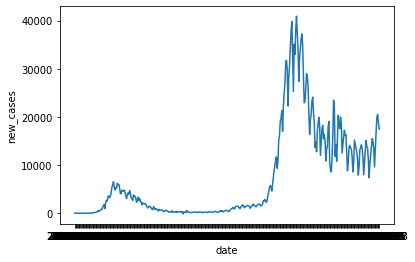

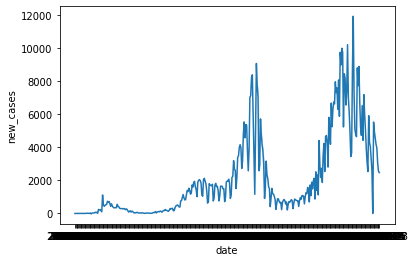

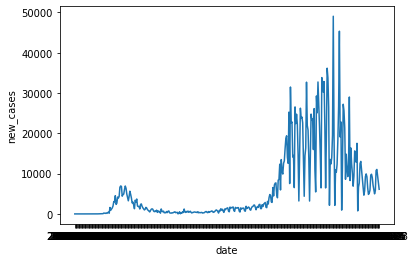

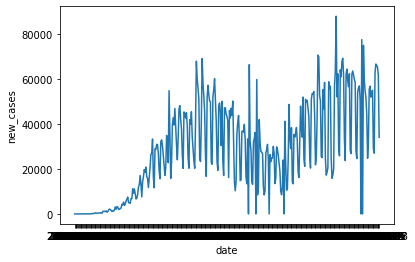

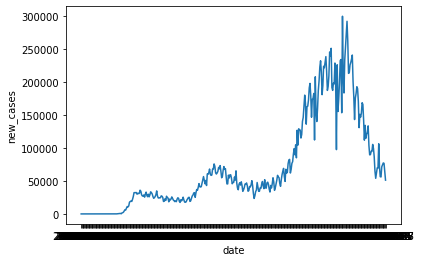

In [ ]:
# fig,axs = plt.subplots(ncols=5, nrows=1, figsize =(30, 10))
# plt.subplots_adjust(right=1.5)
# plt.subplot(1,5,i) #in the loop
# plt.xlabel('{}'.format(i['location']), size=15)
# plt.ylabel('new_cases', size=15, labelpad=12.5)

for i in sample:
    sns.lineplot(x=i['date'], y=i['new_cases'])
    plt.show()

#below applies to the whole df
# for i in data['location'].unique():
#     sns.lineplot(x=data[data['location']==i]['date'], y=data[data['location']==i]['new_cases'])
#     plt.show()

In [ ]:
# for i in sample:
#     sns.lineplot(x=i['date'], y=i['total_deaths'])

## Let's check how the Y variable looks like 

data New_cases Mean: 4968.294628515423
data New_cases Median: 55.0
data New_cases Max: 879905.0
data New_cases Skew: 13.28269797739037


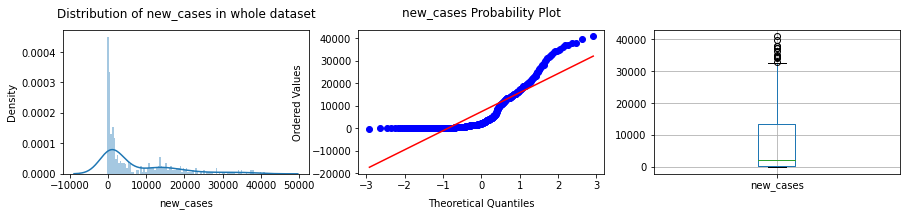

In [ ]:
print('data New_cases Mean: {}'.format(data['new_cases'].mean()))
print('data New_cases Median: {}'.format(data['new_cases'].median()))
print('data New_cases Max: {}'.format(data['new_cases'].max()))
print('data New_cases Skew: {}'.format(data['new_cases'].skew()))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(italy['new_cases'], hist=True, bins = 100, ax=ax1)
probplot(italy['new_cases'], plot=ax2)
italy.boxplot('new_cases', ax=ax3)

ax1.set_xlabel('new_cases', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of new_cases in whole dataset', size=12, y=1.05)
ax2.set_title('new_cases Probability Plot', size=12, y=1.05)

plt.show()

**insert here observations of the above**

## Lets check how variables are correlated with one another

In [ ]:
israelnum=israel.select_dtypes(np.number)

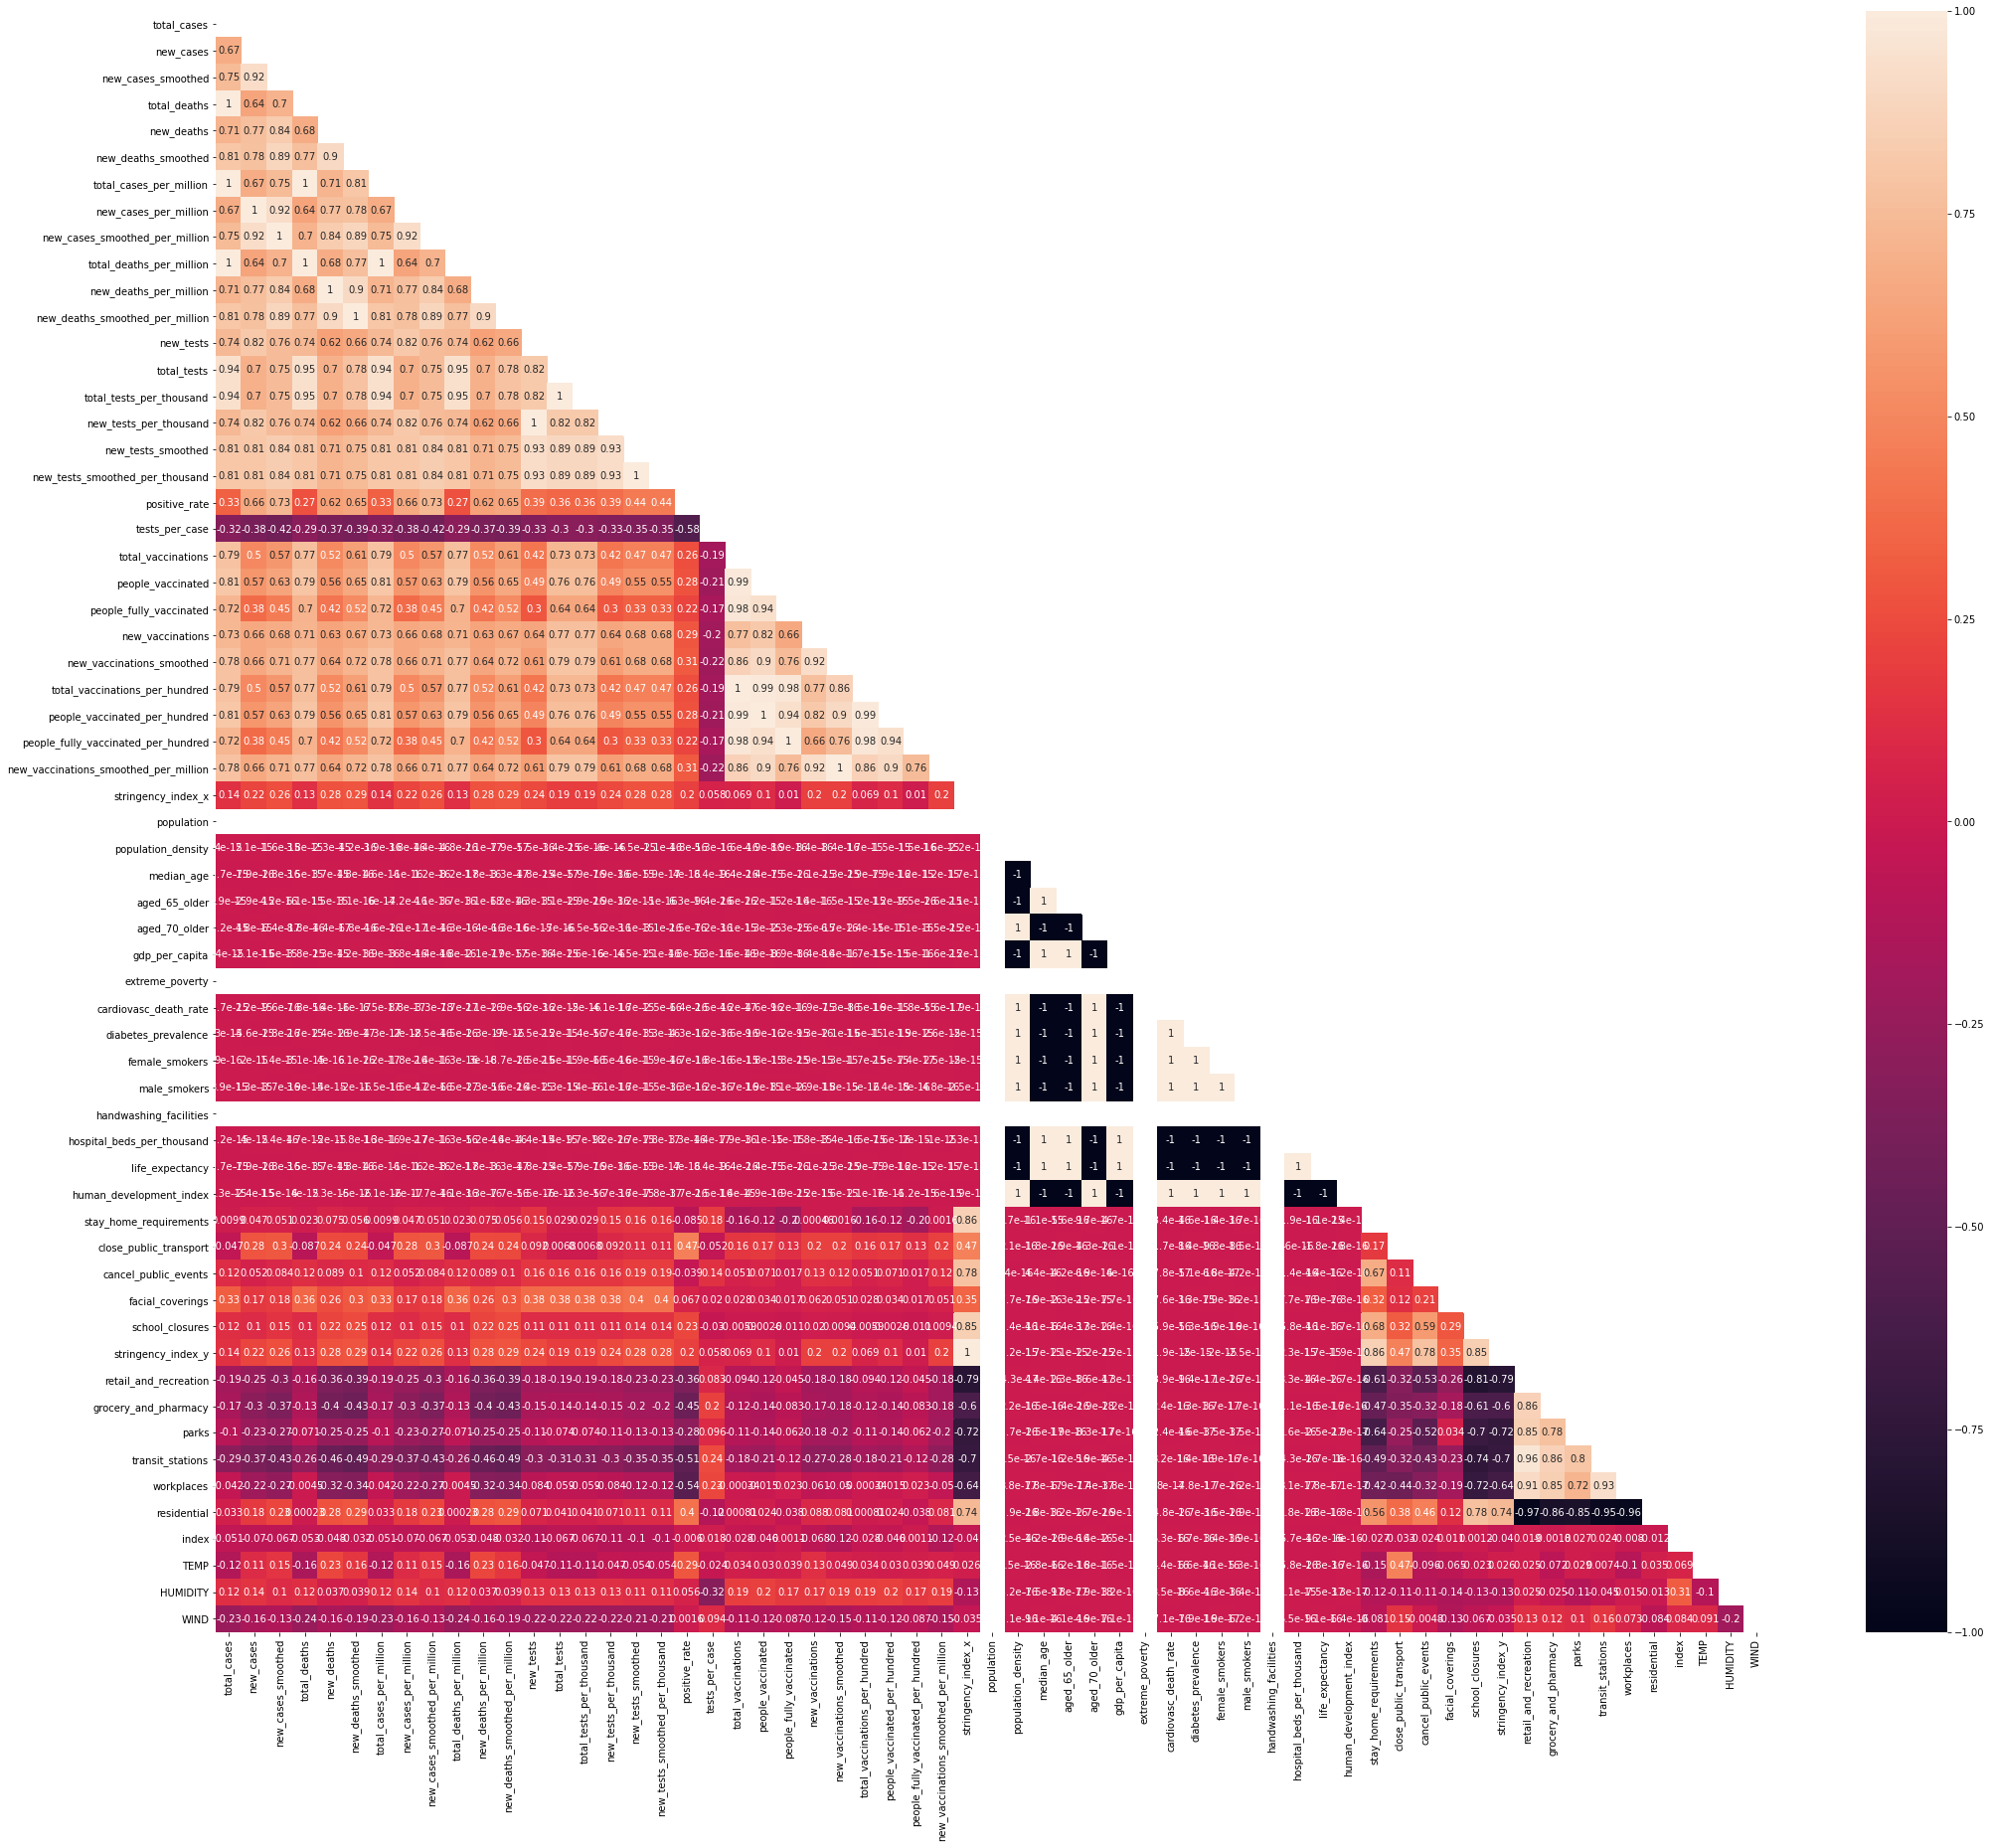

In [ ]:
correlations_matrix= israelnum.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(35, 30))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

New cases is (quite) highly correlated with .....

I have to drop (maybe temporarely) the feature referring to the tests (it goes up as the new cases go up ofc but it does cause them to go up) and all its related ones.

## Checking the effect of constant variables:
* There are some variables that are **constant for each country**, so in order to see the effect one must compare among countries. 
* I should plot those against **the mean** of new (or the max of total) cases for all the countries as see the affect.
* These features are population, handwashing facilities, extreme poverty, median age, aged_65_older,	aged_70_older,	gdp_per_capita,	cardiovasc_death_rate,	diabetes_prevalence,	female_smokers,	male_smokers,	handwashing_facilities,	hospital_beds_per_thousand, life_expectancy. 

In [ ]:
#making a list of constant features
constants=['population', 'handwashing_facilities', 'extreme_poverty', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy']
#removing continents from our df to see effect of contants on new cases
continent=['Africa','Asia','Oceania','Europe','European Union', 'World']
data_countries=data[~data['location'].isin(continent)]

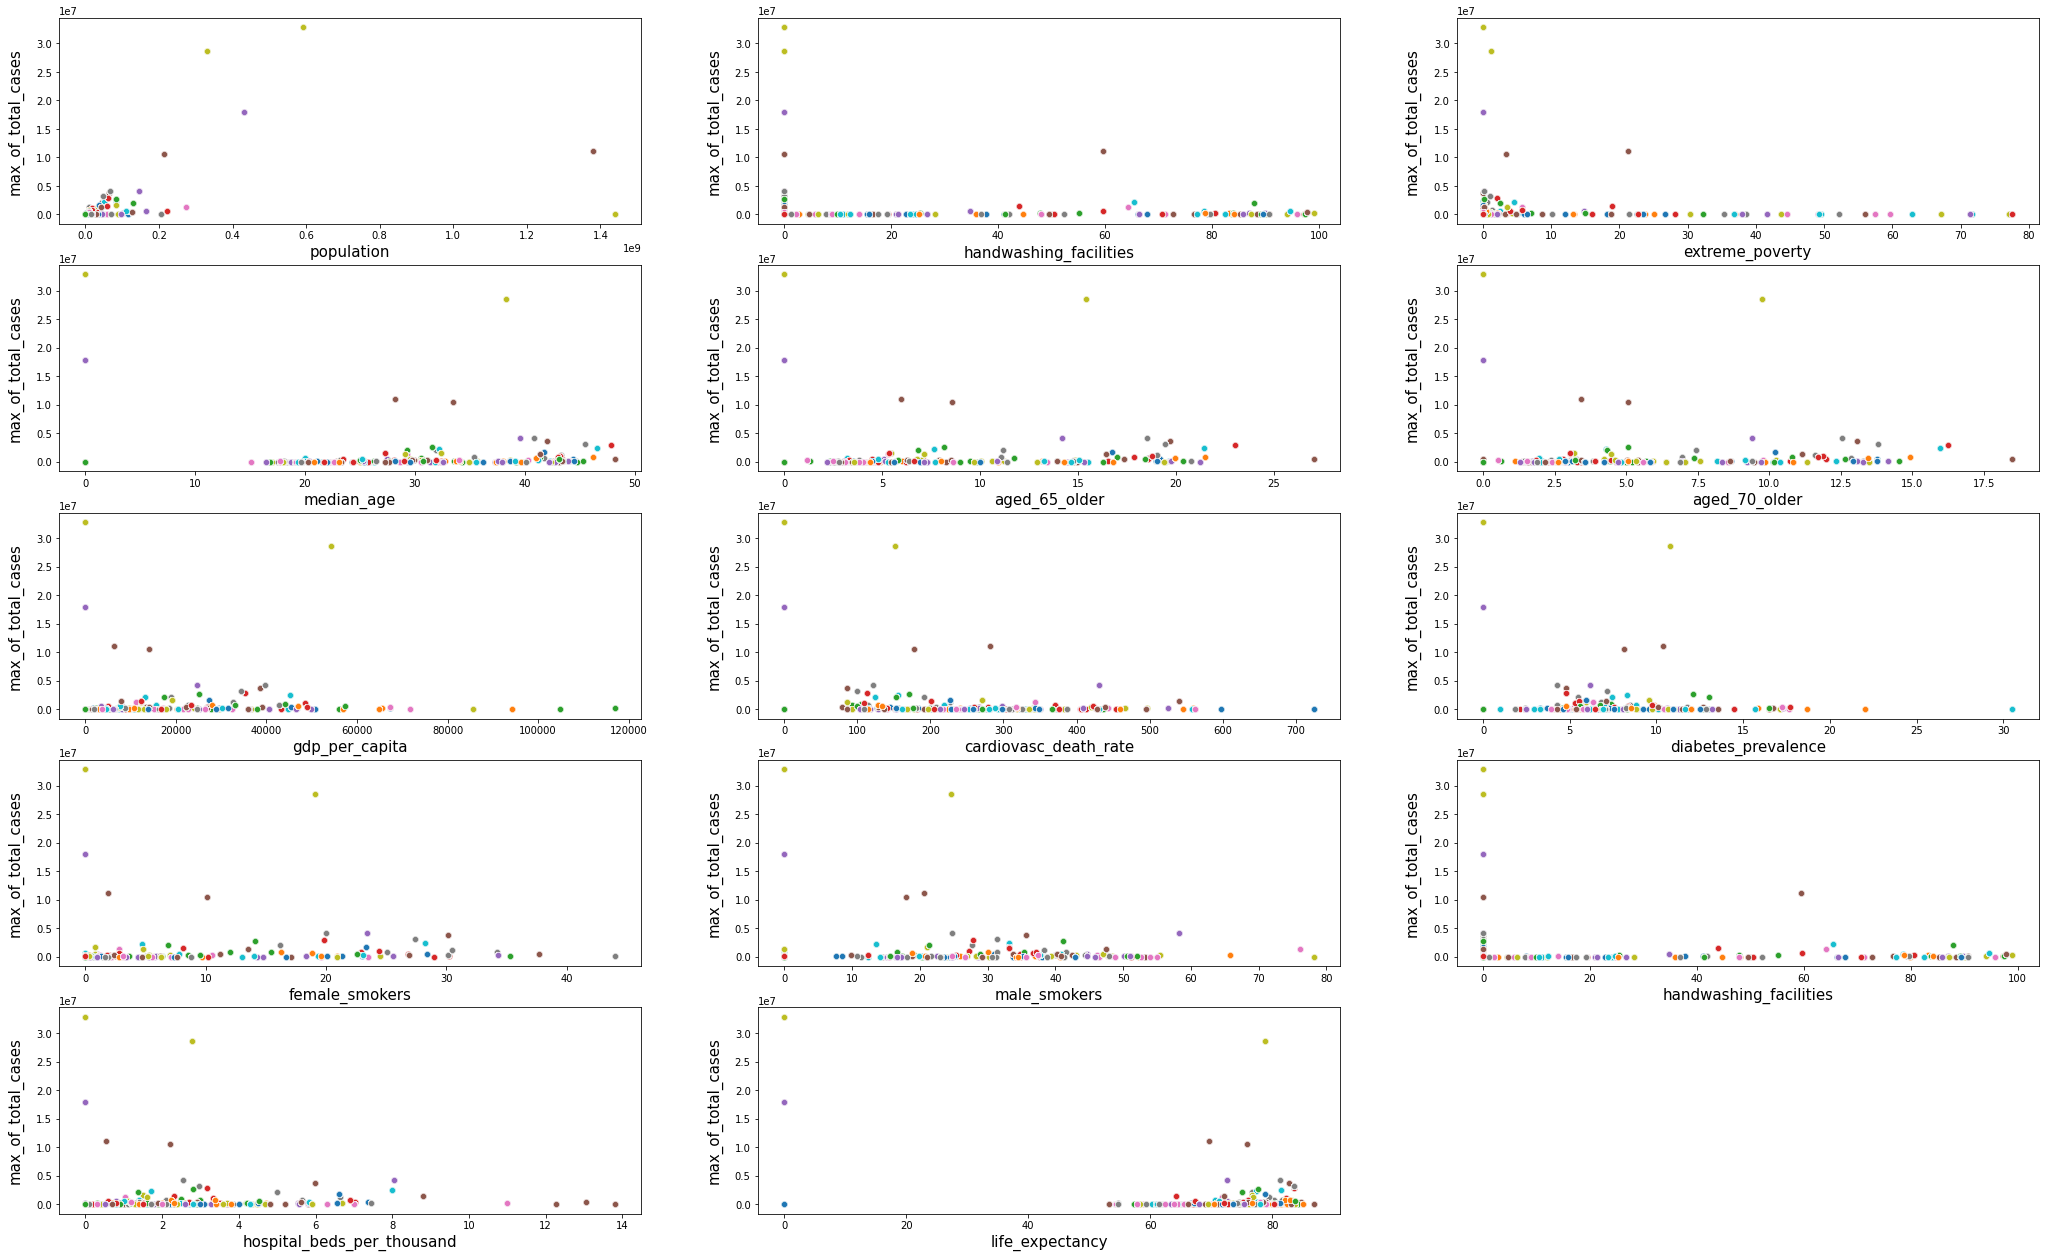

In [ ]:
fig,axs = plt.subplots(ncols=3, nrows=3, figsize =(20, 22))
plt.subplots_adjust(right=1.5)

for j,feature in enumerate(constants,1):
  for i in data_countries['location'].unique():
    plt.subplot(5, 3, j)
    sns.scatterplot(x=data_countries[data_countries['location']==i][feature], 
                    y=data_countries[data_countries['location']==i]['total_cases'].max()
                    # y=data_countries[data_countries['location']==i]['new_cases'].mean() #alternative y axis 
                    # y=data_countries[data_countries['location']==i]['total_deaths'].max() #alternative y axis
                    # ,label=f"country: {i}"
                    )
    #plt.legend()
    plt.xlabel('{}'.format(feature), size=15)
    plt.ylabel('max_of_total_cases', size=15, labelpad=12.5)
    # plt.ylabel('avg_of_new_cases', size=15, labelpad=12.5)
    # plt.ylabel('max_of_total_deaths', size=15, labelpad=12.5)
    # plt.title("{} VS Total Cases".format(feature))

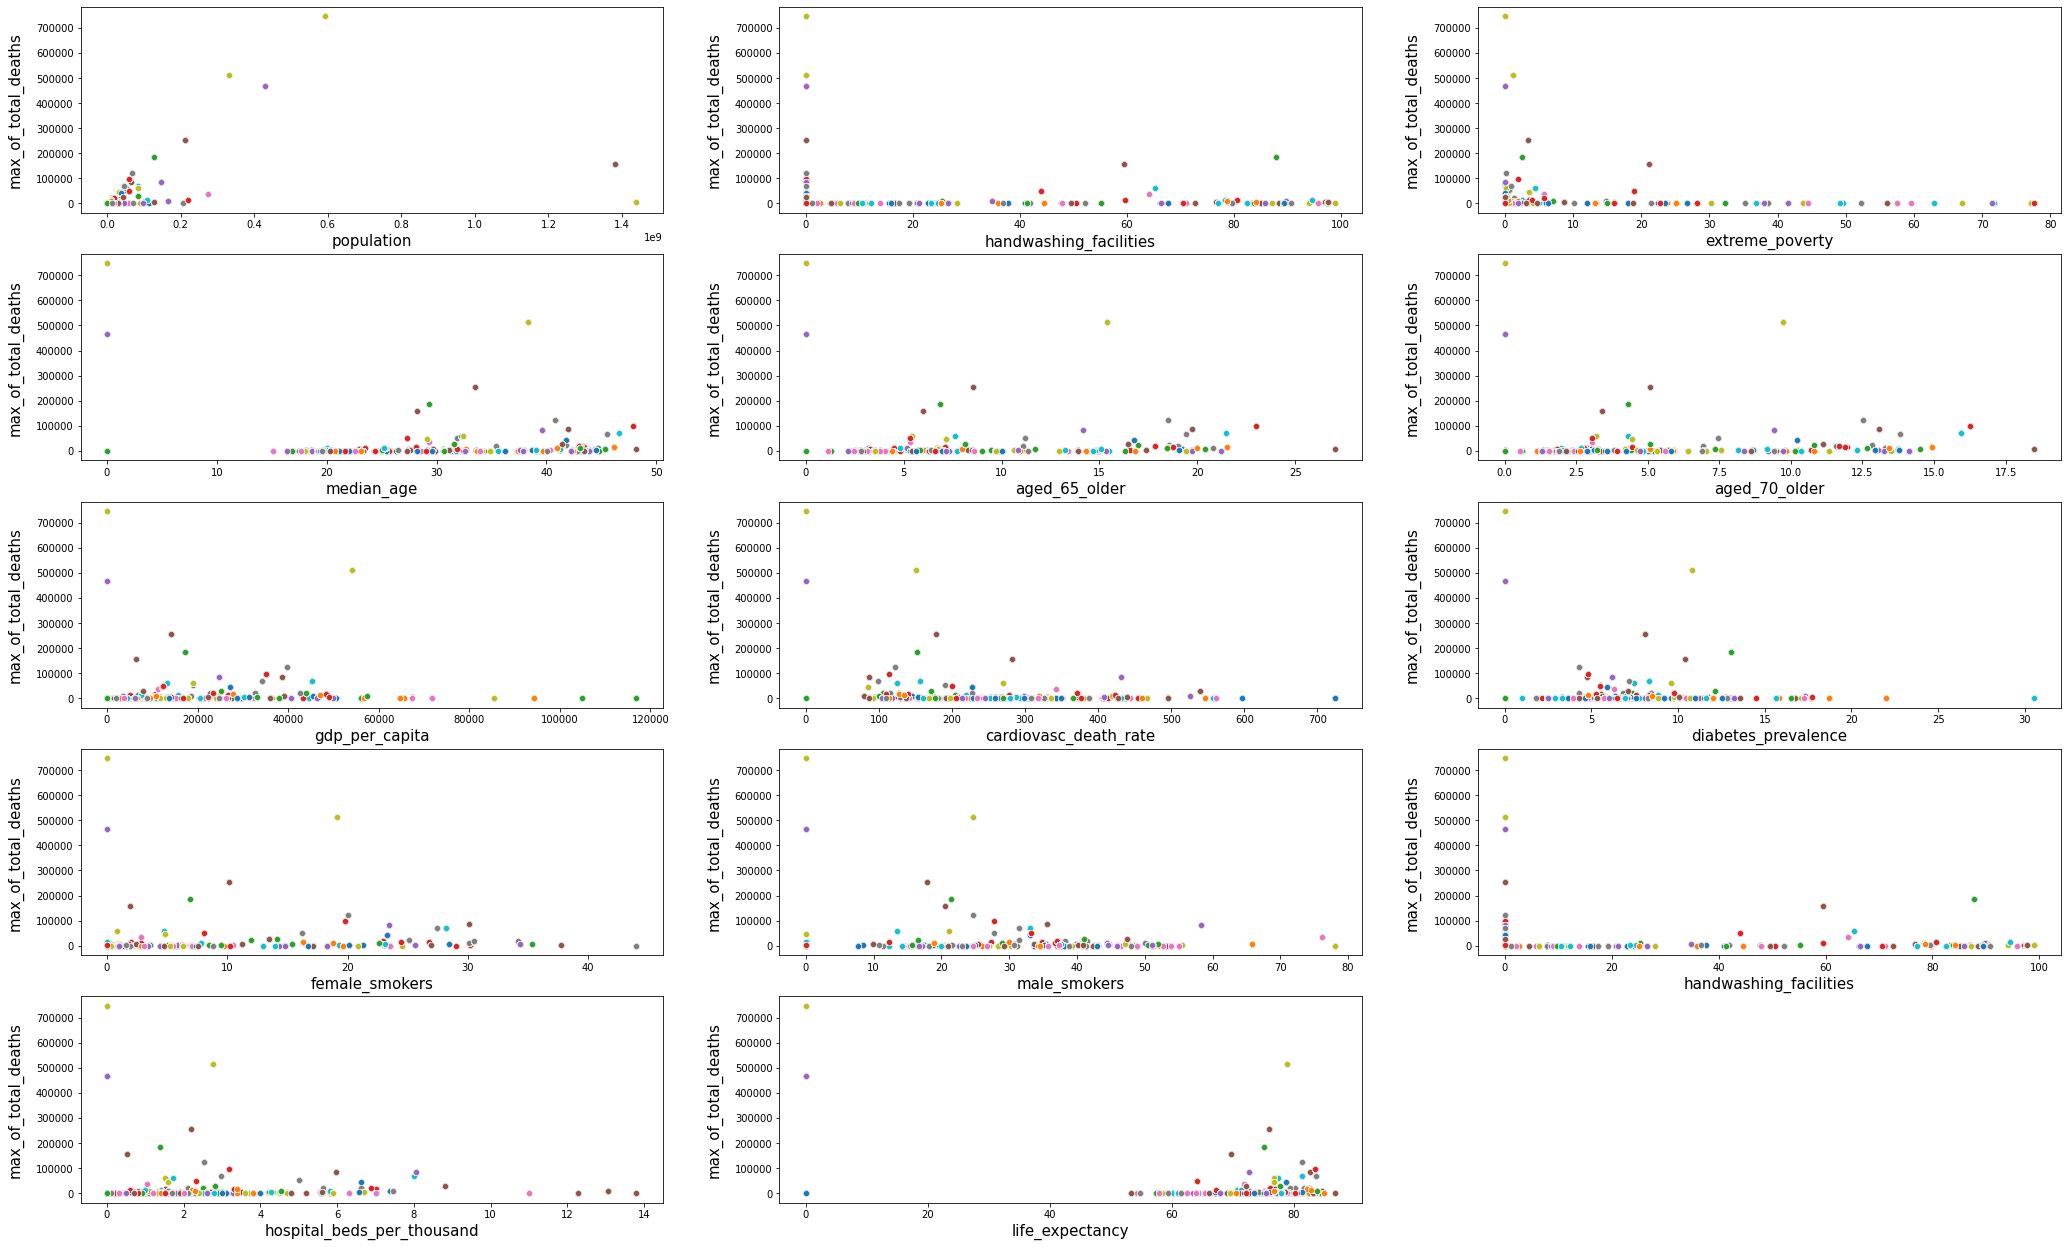

In [40]:
fig,axs = plt.subplots(ncols=3, nrows=3, figsize =(20, 22))
plt.subplots_adjust(right=1.5)

for j,feature in enumerate(constants,1):
  for i in data_countries['location'].unique():
    plt.subplot(5, 3, j)
    sns.scatterplot(x=data_countries[data_countries['location']==i][feature], 
                    # y=data_countries[data_countries['location']==i]['total_cases'].max()
                    # y=data_countries[data_countries['location']==i]['new_cases'].mean() #alternative y axis 
                    y=data_countries[data_countries['location']==i]['total_deaths'].max() #alternative y axis
                    # ,label=f"country: {i}"
                    )
    #plt.legend()
    plt.xlabel('{}'.format(feature), size=15)
    # plt.ylabel('max_of_total_cases', size=15, labelpad=12.5)
    # plt.ylabel('avg_of_new_cases', size=15, labelpad=12.5)
    plt.ylabel('max_of_total_deaths', size=15, labelpad=12.5)
    # plt.title("{} VS Total Cases".format(feature))

**insert here observations of the above**

## Check if there is linear direct correlation among the X's

In [41]:
israelnum= israel.select_dtypes(include=np.number)

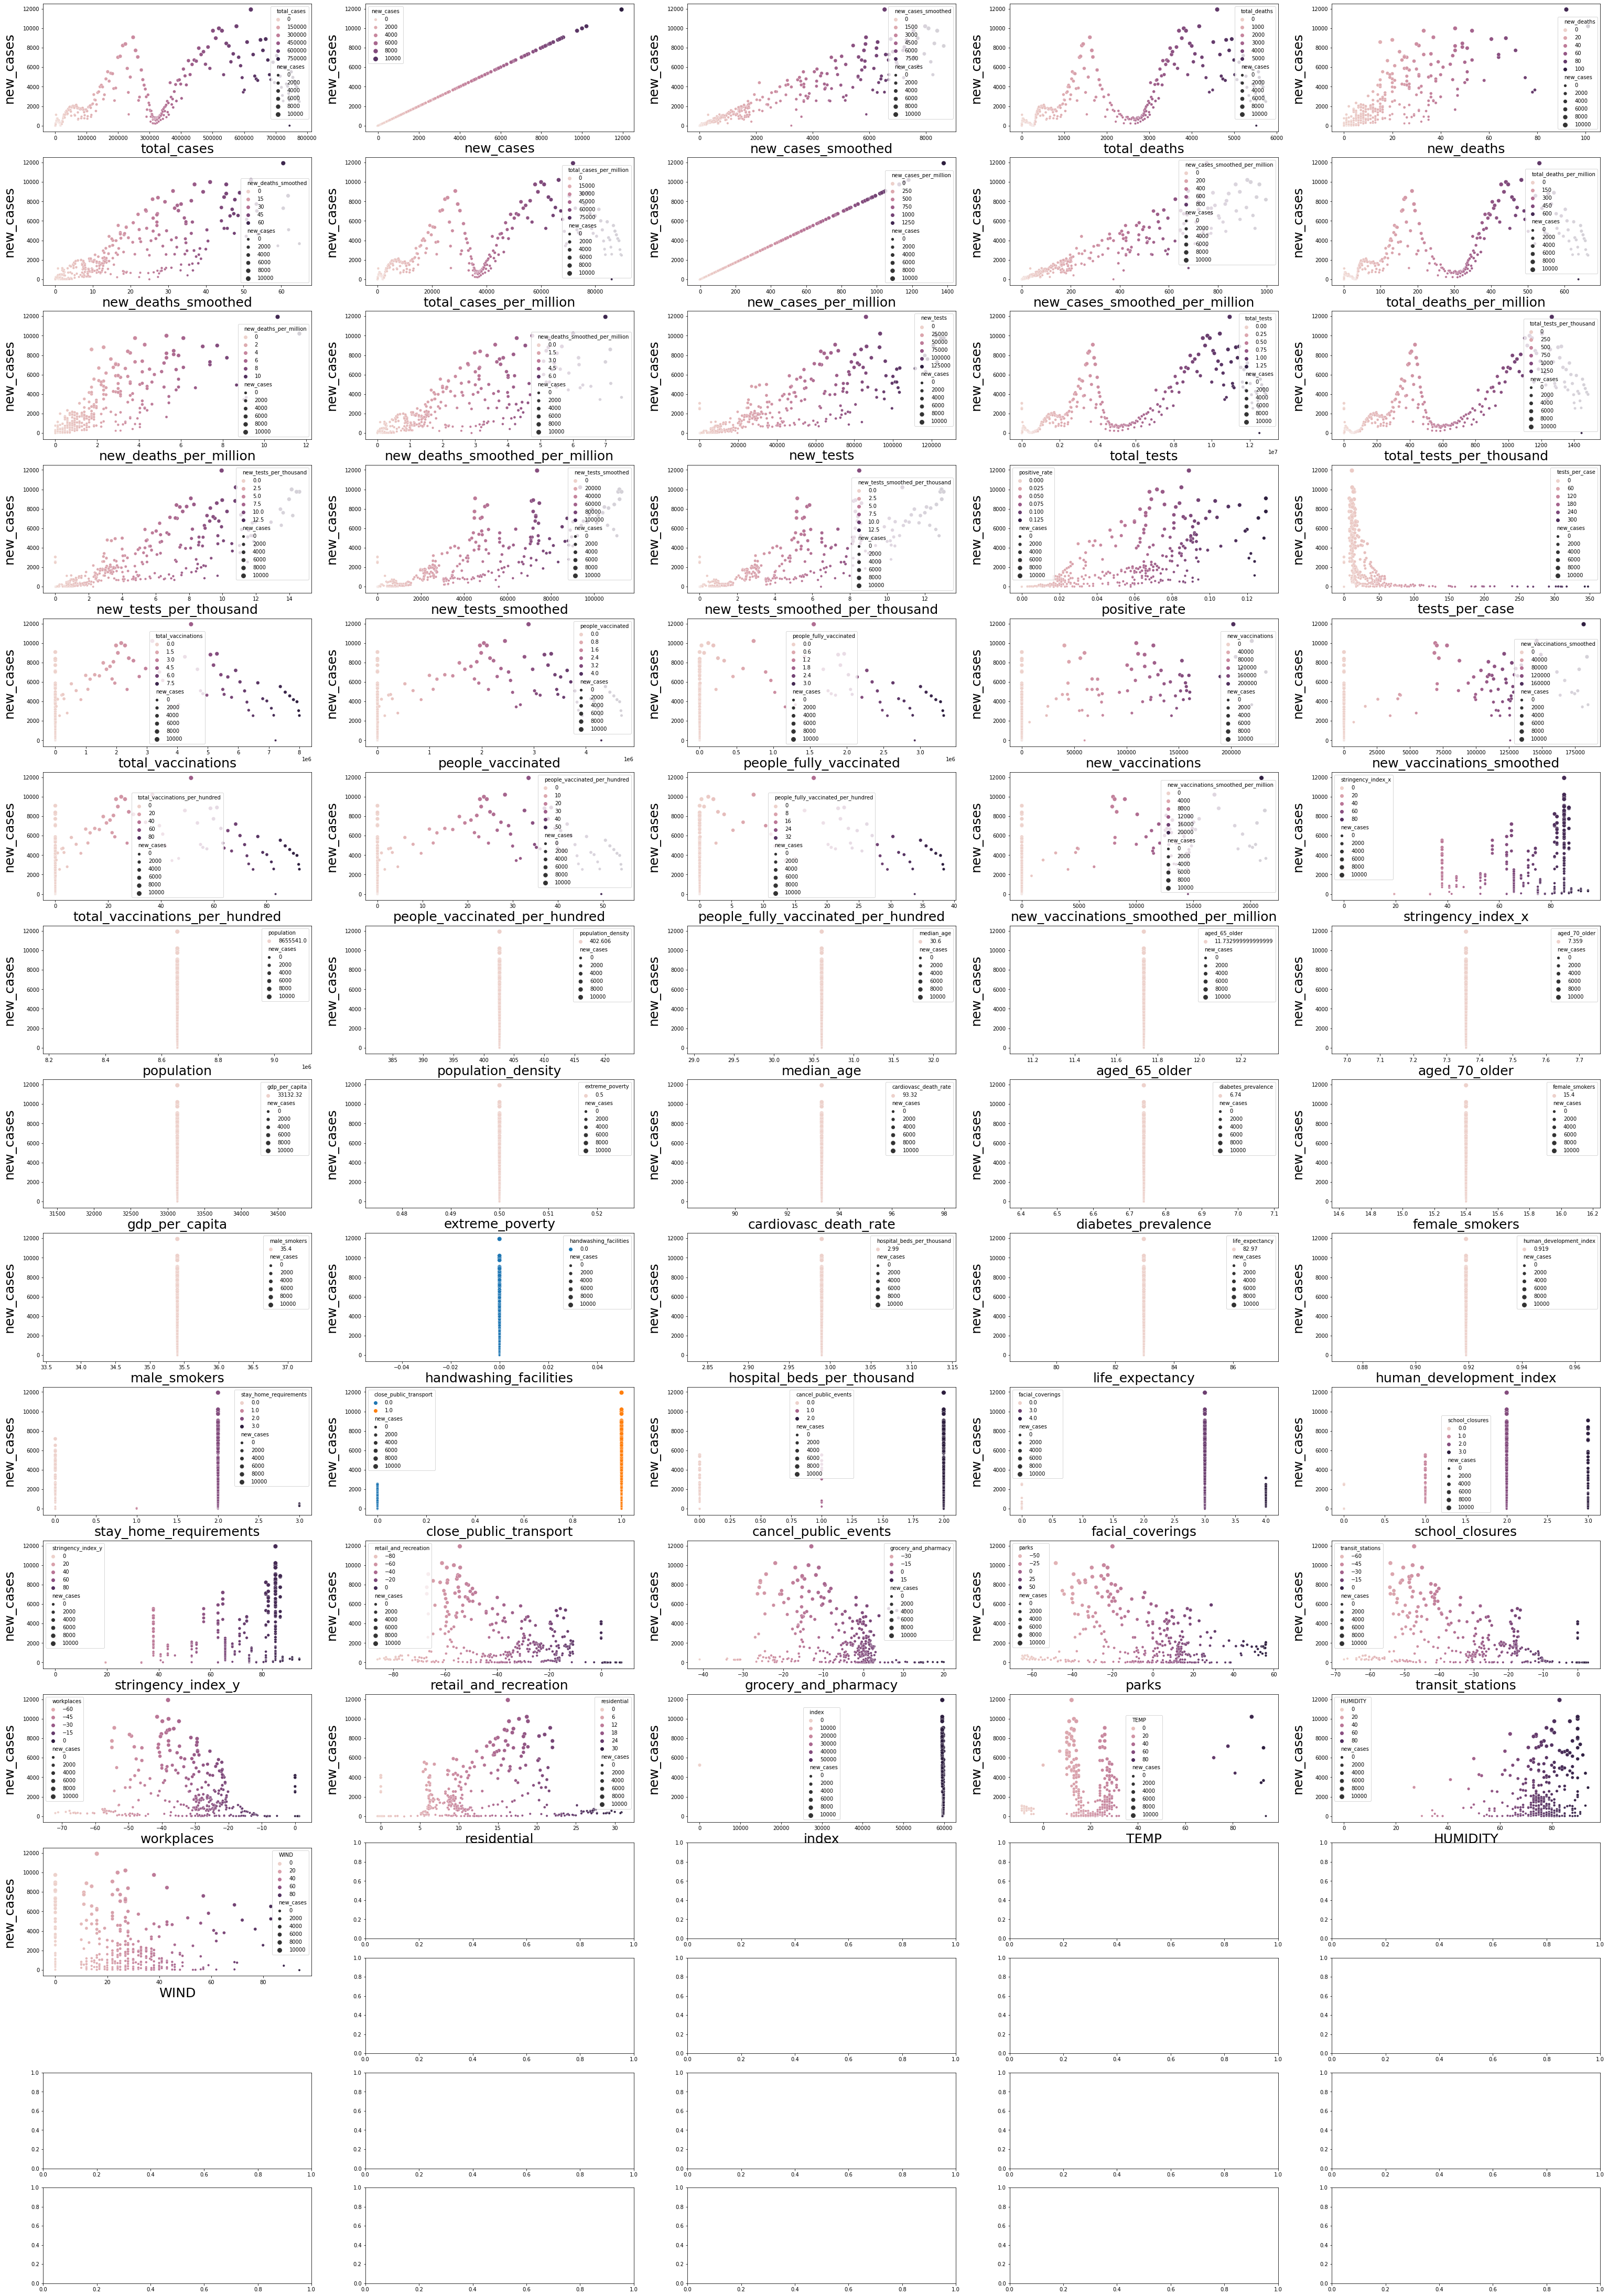

In [42]:
fig,axs = plt.subplots(ncols=5, nrows=20, figsize =(30, 80))
plt.subplots_adjust(right=1.5)
 
for i, feature in enumerate(list(israelnum.columns), 1):    
    plt.subplot(len(israelnum.columns)/4,5, i) #change the first argument according to how many variables are left (num of rows - initial 12)
    sns.scatterplot(x=feature, y='new_cases', hue='{}'.format(feature), cmap = 'OrRd', size='new_cases', data=israelnum)
    plt.xlabel('{}'.format(feature), size=25)
    plt.ylabel('new_cases', size=25, labelpad=12.5)
plt.show()

**insert here observations of the above**

In [ ]:
to_drop=['new_cases_per_million','new_cases_smoothed','new_cases_smoothed_per_million',
         'new_tests_smoothed','new_tests_smoothed_per_thousand','new_tests_per_thousand','new_tests',
         'total_tests_per_thousand','total_tests','new_deaths','new_deaths_per_million','total_cases',
         'total_cases_per_million','new_deaths_smoothed_per_million','new_deaths_smoothed','positive_rate',
         'total_deaths','total_deaths_per_million','stringency_index_y'
         ,'tests_per_case'
         ]

In [ ]:
to_drop2=['new_cases_per_million','new_cases_smoothed','new_cases_smoothed_per_million',
         'new_tests_smoothed','new_tests_smoothed_per_thousand','new_tests_per_thousand','new_tests',
         'total_tests_per_thousand','total_tests','new_deaths','new_deaths_per_million','new_cases',
         'total_cases_per_million','new_deaths_smoothed_per_million','new_deaths_smoothed','positive_rate',
         'total_deaths','total_deaths_per_million','stringency_index_y'
          ,'tests_per_case'
          ]

In [45]:
# if time series doesn't have use for constant values, drop them. Otherwise keep them
drop_constant=['diabetes_prevalence', 'aged_65_older', 'male_smokers', 'hospital_beds_per_thousand', 'female_smokers', 
               'aged_70_older', 'population', 'population_density', 'median_age', 'gdp_per_capita', 'extreme_poverty', 
               'cardiovasc_death_rate', 'handwashing_facilities', 'life_expectancy', 'human_development_index']

In [46]:
drop_vacc=['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 
          #  'new_vaccinations', 
           'new_vaccinations_smoothed','total_vaccinations_per_hundred', 
           'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million']

## Kbest
will now help to identify most important features for my numerical Y. In order to do that I will get rid of all the categoricals in a new df

the most important features seem to be the ones containing indirectly information about the Y itself --> drop
from new_cases_per_million until positive_rate + total_deaths & total_deaths_per_million

In [47]:
israelnum= israel.select_dtypes(include=np.number)
israelnum = israelnum.drop(columns=to_drop)

israelnum = israelnum.drop(columns=drop_constant)

israelnum = israelnum.drop(columns=drop_vacc)

In [48]:
X = israelnum
y = israelnum['new_cases']

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
kbest = SelectKBest(f_regression, k=len(israelnum.columns)).fit_transform(X, y)
# Here we chose 10 so that is easier to analyze results later, as we will see
selected = pd.DataFrame(kbest)
selected.head()

# To check the scores
model = SelectKBest(f_regression, k=len(israelnum.columns)).fit(X, y)
df =pd.DataFrame(data = model.scores_, columns = ['score'])
df['Column'] = israelnum.columns
# Sorting data
print(df.sort_values(by = ['score'], ascending = False).head(57))


           score                  Column
0   1.729382e+18               new_cases
1   3.028415e+02        new_vaccinations
11  6.003424e+01        transit_stations
9   3.869083e+01    grocery_and_pharmacy
4   3.357321e+01  close_public_transport
8   2.460309e+01   retail_and_recreation
10  2.101382e+01                   parks
2   2.019332e+01      stringency_index_x
12  1.891764e+01              workplaces
13  1.262644e+01             residential
6   1.158097e+01        facial_coverings
17  9.958875e+00                    WIND
16  7.936120e+00                HUMIDITY
15  4.324979e+00                    TEMP
7   4.088640e+00         school_closures
14  1.873312e+00                   index
5   1.054907e+00    cancel_public_events
3   8.580260e-01  stay_home_requirements


In [49]:
# italynum= italy.select_dtypes(include=np.number)
# italynum = italynum.drop(columns=to_drop)

# italynum = italynum.drop(columns=drop_constant)

# italynum = italynum.drop(columns=drop_vacc)

In [50]:
# italy['people_fully_vaccinated'].plot()

In [51]:
# italy['new_cases'].plot()

In [52]:
# sns.scatterplot(x=israel['people_fully_vaccinated'],y=israel['new_cases'], hue=israel['people_fully_vaccinated'], size=israel['new_cases'])
# plt.show()

In [53]:
from scipy import stats
def feat_log_box(df, feature, bins = 100):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) and x!=0 else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')
    # print(lmbda)
    return df
    
# feat_log_box(data, 'total_cla', 100)

# Time Series / ARIMAX

In [54]:
data['date']=pd.to_datetime(data['date'])

In [55]:
italy=data[data['location']=='Italy']

In [56]:
italy.index = pd.DatetimeIndex(italy['date'], freq='D')

In [57]:
ita= italy.select_dtypes(include=np.number)
ita = ita.drop(columns=to_drop)

ita = ita.drop(columns=drop_constant)

ita = ita.drop(columns=drop_vacc)

In [58]:
ita.head(2)

new_cases  new_vaccinations  stringency_index_x  \
date                                                          
2020-01-31        2.0               0.0               19.44   
2020-02-01        0.0               0.0               19.44   

            stay_home_requirements  close_public_transport  \
date                                                         
2020-01-31                     0.0                     0.0   
2020-02-01                     0.0                     0.0   

            cancel_public_events  facial_coverings  school_closures  \
date                                                                  
2020-01-31                   0.0               0.0              0.0   
2020-02-01                   0.0               0.0              0.0   

            retail_and_recreation  grocery_and_pharmacy  parks  \
date                                                             
2020-01-31                    0.0                   0.0    0.0   
2020-02-01                    0.0                   0.0    0.0   

            transit_stations  workplaces  residential    index  TEMP  \
date                                                                   
2020-01-31               0.0         0.0          0.0  59914.0  12.0   
2020-02-01               0.0         0.0          0.0  59915.0  13.0   

            HUMIDITY  WIND  
date                        
2020-01-31      76.3  56.0  
2020-02-01      86.5  74.0

In [59]:
ita.shape

(395, 18)

In [60]:
#removing neg values (problem for scaling data)
# ita = ita[(ita[['new_cases']] > 0).all(axis=1)]

In [61]:
# drp=['iso_code','continent','location']
# israel=israel.drop(columns=drp)

In [62]:
# italy.reset_index()

In [63]:
# israel['date'].apply(add_freq)

mean : 7405.734177215189


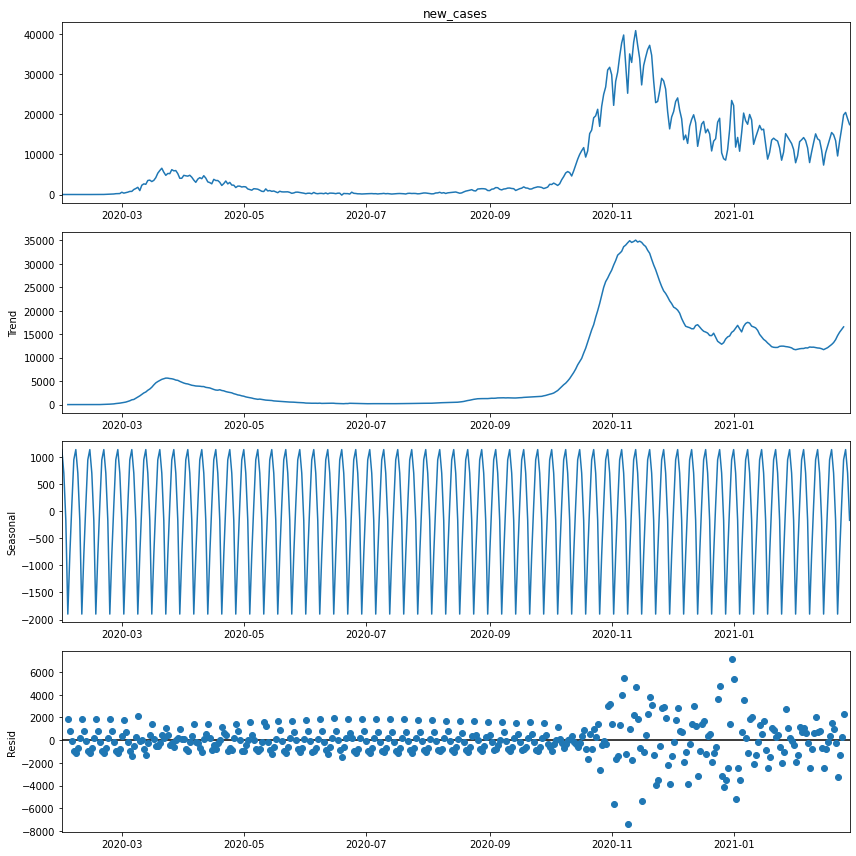

In [64]:
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline
print('mean :' , ita['new_cases'].mean())
#res = sm.tsa.seasonal_decompose(occupancy.CO2)
res = sm.tsa.seasonal_decompose(ita['new_cases'],freq=7)

with plt.rc_context():
    plt.rc("figure", figsize=(12,12))
    res.plot()

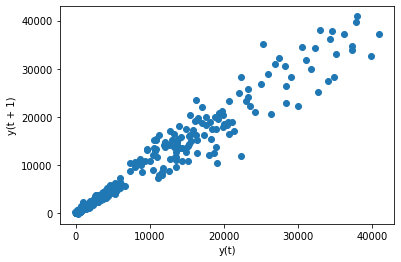

In [65]:
from pandas.plotting import lag_plot

lag_plot(ita['new_cases'])
# import matplotlib.pyplot as plt
# occupancy.plot(x=occupancy.CO2, y=occupancy.CO2)

differencing comparison shows that one is my best option for lowering the noise and making my series have minimum standard deviation

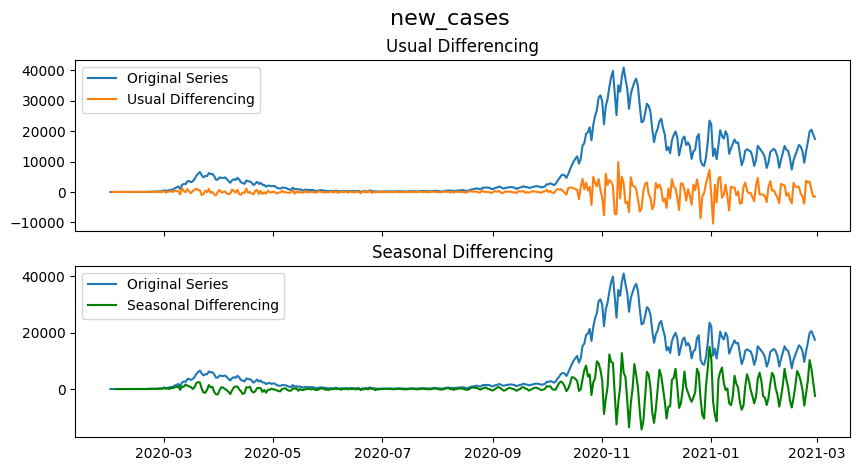

In [66]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(ita['new_cases'][:], label='Original Series')
axes[0].plot(ita['new_cases'][:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Diff
axes[1].plot(ita['new_cases'][:], label='Original Series')
axes[1].plot(ita['new_cases'][:].diff(3), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('new_cases', fontsize=16)
plt.show()

In [67]:
steps=-7
predidf= ita.copy()
predidf['actual']=predidf['new_cases'].shift(steps)
predidf.tail(8)

new_cases  new_vaccinations  stringency_index_x  \
date                                                          
2021-02-21    13450.0           49930.0               82.41   
2021-02-22     9617.0          103475.0               82.41   
2021-02-23    13299.0          103032.0               82.41   
2021-02-24    16402.0          115898.0               82.41   
2021-02-25    19871.0          120580.0               82.41   
2021-02-26    20488.0          126193.0               82.41   
2021-02-27    18902.0          116123.0               82.41   
2021-02-28    17440.0               0.0               82.41   

            stay_home_requirements  close_public_transport  \
date                                                         
2021-02-21                     2.0                     1.0   
2021-02-22                     2.0                     1.0   
2021-02-23                     2.0                     1.0   
2021-02-24                     2.0                     1.0   
2021-02-25                     2.0                     1.0   
2021-02-26                     2.0                     1.0   
2021-02-27                     2.0                     1.0   
2021-02-28                     2.0                     1.0   

            cancel_public_events  facial_coverings  school_closures  \
date                                                                  
2021-02-21                   2.0               4.0              3.0   
2021-02-22                   2.0               4.0              3.0   
2021-02-23                   2.0               4.0              3.0   
2021-02-24                   2.0               4.0              3.0   
2021-02-25                   2.0               4.0              3.0   
2021-02-26                   2.0               4.0              3.0   
2021-02-27                   2.0               4.0              3.0   
2021-02-28                   2.0               4.0              3.0   

            retail_and_recreation  grocery_and_pharmacy  parks  \
date                                                             
2021-02-21                -31.143                -6.143 -1.429   
2021-02-22                -31.143                -5.857 -0.286   
2021-02-23                -31.286                -5.571  1.429   
2021-02-24                  0.000                 0.000  0.000   
2021-02-25                  0.000                 0.000  0.000   
2021-02-26                  0.000                 0.000  0.000   
2021-02-27                  0.000                 0.000  0.000   
2021-02-28                  0.000                 0.000  0.000   

            transit_stations  workplaces  residential    index  TEMP  \
date                                                                   
2021-02-21           -36.143     -23.143        8.714  59935.0  10.0   
2021-02-22           -35.571     -22.429        8.429  59936.0  10.0   
2021-02-23           -35.000     -21.857        8.286  59937.0  13.0   
2021-02-24             0.000       0.000        0.000  59938.0  13.0   
2021-02-25             0.000       0.000        0.000  59939.0  11.0   
2021-02-26             0.000       0.000        0.000  59940.0   8.0   
2021-02-27             0.000       0.000        0.000  59941.0  12.0   
2021-02-28             0.000       0.000        0.000  59942.0  10.0   

            HUMIDITY  WIND   actual  
date                                 
2021-02-21      63.7  62.0  17440.0  
2021-02-22      75.5  69.0      NaN  
2021-02-23      82.9  98.0      NaN  
2021-02-24      78.7  16.0      NaN  
2021-02-25      76.3  16.0      NaN  
2021-02-26      69.8  11.0      NaN  
2021-02-27      62.0  16.0      NaN  
2021-02-28      51.1  15.0      NaN

In [68]:
predidf=predidf.dropna()
predidf['actual'].isna().sum()

0

In [69]:
# predidf['actual']=boxcox(predidf['actual'], 0.1226731859973334)
# predidf['actual']=(predidf['actual'].ffill() + predidf['actual'].bfill())/2

In [70]:
#target
targ=pd.DataFrame(predidf['actual'])

#Xs
exo=predidf.drop(columns='actual')
exo=exo.drop(columns='new_cases')

In [71]:
train_size=int(len(ita) *0.87)
test_size = int(len(ita)) - train_size
train_X, train_y = exo[:train_size].dropna(), targ[:train_size].dropna()
test_X, test_y = exo[train_size:].dropna(), targ[train_size:].dropna()

In [72]:
#minmaxscaler with two differet object (one used on Xs, another on Ys so we can do the inverse later)

from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = sc_in.fit_transform(train_X)
train_X_scaled =pd.DataFrame(train_X_scaled)

test_X_scaled = sc_in.transform(test_X)
test_X_scaled =pd.DataFrame(test_X_scaled)

sc_out = MinMaxScaler(feature_range=(0, 1))
train_y_scaled = sc_out.fit_transform(train_y)
train_y_scaled =pd.DataFrame(train_y_scaled)

test_y_scaled = sc_out.transform(test_y)
test_y_scaled =pd.DataFrame(test_y_scaled)


In [73]:
train_X_scaled.rename(columns={0:'new_vaccinations', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                  4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                  8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                  13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
train_X_scaled.index=train_X.index

test_X_scaled.rename(columns={0:'new_vaccinations', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                  4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                  8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                  13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
test_X_scaled.index=test_X.index

In [74]:
train_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
train_y_scaled.index=train_y.index
train_y_scaled.head(2)

test_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
test_y_scaled.index=test_y.index
test_y_scaled.head(2)

new_cases_next_week
date                           
2021-01-08             0.396882
2021-01-09             0.400926

In [75]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

(343, 17)
(343, 1)
(45, 17)
(45, 1)


In [76]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [77]:
y_test=targ['actual'][:train_size].dropna()
test_adf(y_test, "new cases")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary new cases


In [78]:
# test_adf(y_test.diff(1), 'new cases')

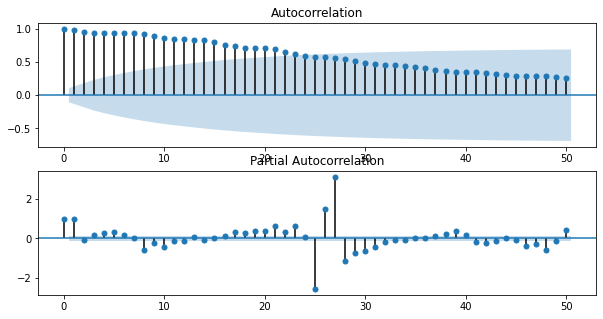

In [79]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

In [80]:
from pmdarima.arima import auto_arima
model=auto_arima(train_y_scaled, 
                  exogenous= train_X_scaled,
                  start_p=1, start_q=1, 
                  max_p=7, max_q=7, 
                  d=1, max_d=7,
                  trace=True, 
                  error_action='ignore', 
                  # seasonal=True, m=1,
                  suppress_warnings=True, 
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1077.750, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1079.877, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1079.389, Time=1.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1079.726, Time=2.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1081.596, Time=0.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.341 seconds


In [81]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  343
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 558.798
Date:                Mon, 15 Mar 2021   AIC                          -1081.596
Time:                        14:59:57   BIC                          -1012.570
Sample:                    01-31-2020   HQIC                         -1054.098
                         - 01-07-2021                                         
Covariance Type:                  opg                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
new_vaccinations          -0.1584      0.053     -2.962      0.003      -0.263      -0.054
stringency_index_x         0.1006      0.169      0.595      0.552      -0.231       0.432
stay_home_requirements     0.0575      0.088      0.654      0.513      -0.115       0.230
close_public_transport    -0.0458      0.052     -0.873      0.383      -0.149       0.057
cancel_public_events      -0.1179   6.16e-07  -1.91e+05      0.000      -0.118      -0.118
facial_coverings           0.0120    2.2e-08   5.46e+05      0.000       0.012       0.012
school_closures            0.0262      0.117      0.225      0.822      -0.202       0.255
retail_and_recreation     -0.0108      0.486     -0.022      0.982      -0.963       0.942
grocery_and_pharmacy       0.3120      0.146      2.137      0.033       0.026       0.598
parks                      0.3744      0.514      0.729      0.466      -0.632       1.381
transit_stations           0.0258      0.569      0.045      0.964      -1.089       1.140
workplaces                 0.3906      0.276      1.416      0.157      -0.150       0.931
residential                0.9360      0.484      1.932      0.053      -0.014       1.885
index                      0.0572      0.127      0.450      0.653      -0.192       0.306
TEMP                      -0.0013      0.048     -0.026      0.979      -0.095       0.093
HUMIDITY                  -0.0016      0.097     -0.016      0.987      -0.192       0.189
WIND                       0.0012      0.023      0.049      0.961      -0.045       0.047
sigma2                     0.0022   9.21e-05     24.212      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):               667.37
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):              36.96   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.55e+18. Standard errors may be unstable.
"""

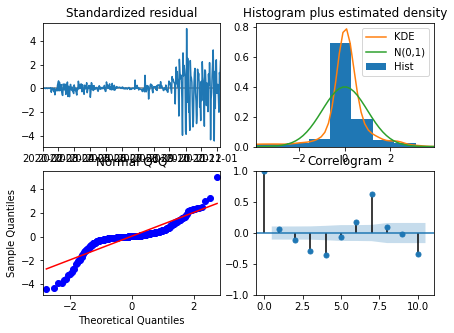

In [82]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [83]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
realmodel= SARIMAX(train_y_scaled, 
 exog=train_X_scaled,
 order=model.order,
 seasonal_order=model.seasonal_order,
 enforce_invertibility=False, enforce_stationarity=False)

In [84]:
results= realmodel.fit()

In [85]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X_scaled)

In [86]:
act= pd.DataFrame(test_y_scaled)

In [87]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['new_cases_next_week'] = act['new_cases_next_week']
predictions.rename(columns={'predicted_mean':'predicted'}, inplace=True)

In [88]:
predictions['predicted']=predictions[(predictions['predicted'] > -0.5).replace(predictions['predicted'].mean())]

In [89]:
predictions=predictions.dropna()

In [90]:
from scipy.special import boxcox, inv_boxcox

In [91]:
testPredict = pd.DataFrame(sc_out.inverse_transform(predictions[['predicted']]))
testActual = pd.DataFrame(sc_out.inverse_transform(predictions[['new_cases_next_week']]))

In [92]:
testActual.index = pd.DatetimeIndex(test_y.index, freq='infer')
testPredict.index = pd.DatetimeIndex(test_y.index, freq='infer')

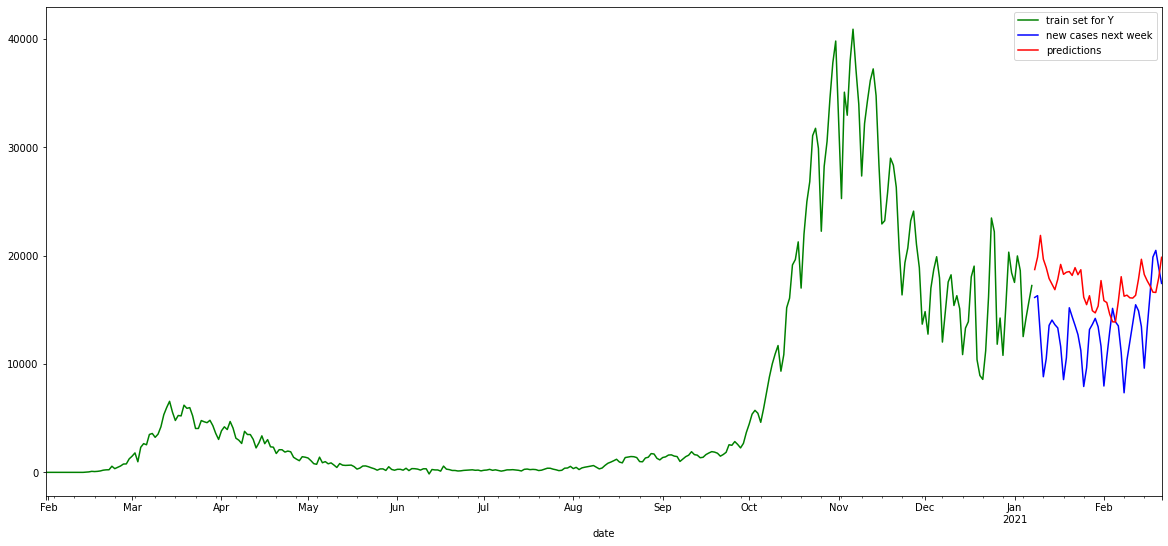

In [93]:
fig, ax = plt.subplots(figsize=(20,9))

train_y.plot(color='green', ax=ax)
testActual.plot(color='blue', ax=ax)
testPredict.plot(color='red', ax=ax)
ax.legend(['train set for Y','new cases next week','predictions'])

In [94]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['predicted'], predictions['new_cases_next_week'])
error

0.13198587098517423

In [95]:
def NEW(user_input):
  country=countries[user_input]
  country.index = pd.DatetimeIndex(country['date'], freq='infer')
  country= country.select_dtypes(include=np.number)
  country = country.drop(columns=to_drop)
  country = country.drop(columns=drop_constant)
  country = country.drop(columns=drop_vacc)
  country = country[(country[['new_cases']] > 0).all(axis=1)]

  res = sm.tsa.seasonal_decompose(country['new_cases'],freq=7)
  with plt.rc_context():
      plt.rc("figure", figsize=(12,12))
      print(res.plot())

  steps=-7
  predidf= country.copy()
  predidf['actual']=predidf['new_cases'].shift(steps)
  predidf=predidf.dropna()
  predidf['actual'].isna().sum()

  targ=pd.DataFrame(predidf['actual'])
  exo=predidf.drop(columns='actual')
  exo=exo.drop(columns='new_cases')

  train_size=int(len(country) *0.87)
  test_size = int(len(country)) - train_size
  train_X, train_y = exo[:train_size].dropna(), targ[:train_size].dropna()
  test_X, test_y = exo[train_size:].dropna(), targ[train_size:].dropna()

  sc_in = MinMaxScaler(feature_range=(0, 1))
  train_X_scaled = sc_in.fit_transform(train_X)
  train_X_scaled =pd.DataFrame(train_X_scaled)

  test_X_scaled = sc_in.transform(test_X)
  test_X_scaled =pd.DataFrame(test_X_scaled)

  sc_out = MinMaxScaler(feature_range=(0, 1))
  train_y_scaled = sc_out.fit_transform(train_y)
  train_y_scaled =pd.DataFrame(train_y_scaled)

  test_y_scaled = sc_out.transform(test_y)
  test_y_scaled =pd.DataFrame(test_y_scaled)

  train_X_scaled.rename(columns={0:'tests_per_case', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                  4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                  8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                  13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
  train_X_scaled.index=train_X.index

  test_X_scaled.rename(columns={0:'tests_per_case', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                    4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                    8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                    13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
  test_X_scaled.index=test_X.index

  train_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
  train_y_scaled.index=train_y.index
  
  test_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
  test_y_scaled.index=test_y.index

  model=auto_arima(train_y_scaled, 
                  exogenous= train_X_scaled,
                  start_p=1, start_q=1, 
                  max_p=7, max_q=7, 
                  d=1, max_d=7,
                  trace=True, 
                  error_action='ignore', 
                  # seasonal=True, m=1,
                  suppress_warnings=True, 
                  stepwise=True)
  print(model.summary())

  model.plot_diagnostics(figsize=(7,5))
  print(plt.show())

  realmodel= SARIMAX(train_y_scaled, 
  exog=train_X_scaled,
  order=model.order,
  seasonal_order=model.seasonal_order,
  enforce_invertibility=False, enforce_stationarity=False)

  results= realmodel.fit()

  predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X_scaled)
  act= pd.DataFrame(test_y_scaled)

  predictions=pd.DataFrame(predictions)
  predictions.reset_index(drop=True, inplace=True)
  predictions.index=test_X.index
  predictions['new_cases_next_week'] = act['new_cases_next_week']
  predictions.rename(columns={'predicted_mean':'predicted'}, inplace=True)

  predictions['predicted']=predictions[(predictions['predicted'] > -0.5).replace(predictions['predicted'].mean())]
  predictions=predictions.dropna()

  testPredict = pd.DataFrame(sc_out.inverse_transform(predictions[['predicted']]))
  testActual = pd.DataFrame(sc_out.inverse_transform(predictions[['new_cases_next_week']]))
  testActual.index = pd.DatetimeIndex(test_y.index, freq='infer')
  testPredict.index = pd.DatetimeIndex(test_y.index, freq='infer')

  fig, ax = plt.subplots(figsize=(20,9))
  print(train_y.plot(color='green', ax=ax))
  print(testActual.plot(color='blue', ax=ax))
  print(testPredict.plot(color='red', ax=ax))
  print(ax.legend(['train set for Y','test set for Y','predictions']))

  error=rmse(predictions['predicted'], predictions['new_cases_next_week'])
  print('error is: ', error)

In [96]:
def total(user_input):
  country=countries[user_input]
  country.index = pd.DatetimeIndex(country['date'], freq='infer')
  country= country.select_dtypes(include=np.number)
  country = country.drop(columns=to_drop2)
  country = country.drop(columns=drop_constant)
  country = country.drop(columns=drop_vacc)
  country = country[(country[['total_cases']] > 0).all(axis=1)]

  res = sm.tsa.seasonal_decompose(country['total_cases'],freq=7)
  with plt.rc_context():
      plt.rc("figure", figsize=(12,12))
      print(res.plot())

  steps=-7
  predidf= country.copy()
  predidf['actual']=predidf['total_cases'].shift(steps)
  predidf=predidf.dropna()
  predidf['actual'].isna().sum()

  targ=pd.DataFrame(predidf['actual'])
  exo=predidf.drop(columns='actual')
  exo=exo.drop(columns='total_cases')

  train_size=int(len(country) *0.87)
  test_size = int(len(country)) - train_size
  train_X, train_y = exo[:train_size].dropna(), targ[:train_size].dropna()
  test_X, test_y = exo[train_size:].dropna(), targ[train_size:].dropna()

  sc_in = MinMaxScaler(feature_range=(0, 1))
  train_X_scaled = sc_in.fit_transform(train_X)
  train_X_scaled =pd.DataFrame(train_X_scaled)

  test_X_scaled = sc_in.transform(test_X)
  test_X_scaled =pd.DataFrame(test_X_scaled)

  sc_out = MinMaxScaler(feature_range=(0, 1))
  train_y_scaled = sc_out.fit_transform(train_y)
  train_y_scaled =pd.DataFrame(train_y_scaled)

  test_y_scaled = sc_out.transform(test_y)
  test_y_scaled =pd.DataFrame(test_y_scaled)

  train_X_scaled.rename(columns={0:'tests_per_case', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                  4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                  8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                  13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
  train_X_scaled.index=train_X.index

  test_X_scaled.rename(columns={0:'tests_per_case', 1:'stringency_index_x', 2:'stay_home_requirements', 3:'close_public_transport', 
                    4:'cancel_public_events', 5:'facial_coverings', 6:'school_closures',7:'retail_and_recreation',
                    8:'grocery_and_pharmacy', 9:'parks',10:'transit_stations',11:'workplaces',12:'residential',
                    13:'index',14:'TEMP',15:'HUMIDITY',16:'WIND'}, inplace=True)
  test_X_scaled.index=test_X.index

  train_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
  train_y_scaled.index=train_y.index
  
  test_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
  test_y_scaled.index=test_y.index

  model=auto_arima(train_y_scaled, 
                  exogenous= train_X_scaled,
                  start_p=1, start_q=1, 
                  max_p=7, max_q=7, 
                  d=1, max_d=7,
                  trace=True, 
                  error_action='ignore', 
                  # seasonal=True, m=1,
                  suppress_warnings=True, 
                  stepwise=True)
  print(model.summary())

  model.plot_diagnostics(figsize=(7,5))
  print(plt.show())

  realmodel= SARIMAX(train_y_scaled, 
  exog=train_X_scaled,
  order=model.order,
  seasonal_order=model.seasonal_order,
  enforce_invertibility=False, enforce_stationarity=False)

  results= realmodel.fit()

  predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X_scaled)
  act= pd.DataFrame(test_y_scaled)

  predictions=pd.DataFrame(predictions)
  predictions.reset_index(drop=True, inplace=True)
  predictions.index=test_X.index
  predictions['new_cases_next_week'] = act['new_cases_next_week']
  predictions.rename(columns={'predicted_mean':'predicted'}, inplace=True)

  predictions['predicted']=predictions[(predictions['predicted'] > -0.5).replace(predictions['predicted'].mean())]
  predictions=predictions.dropna()

  testPredict = pd.DataFrame(sc_out.inverse_transform(predictions[['predicted']]))
  testActual = pd.DataFrame(sc_out.inverse_transform(predictions[['new_cases_next_week']]))
  testActual.index = pd.DatetimeIndex(test_y.index, freq='infer')
  testPredict.index = pd.DatetimeIndex(test_y.index, freq='infer')

  fig, ax = plt.subplots(figsize=(20,9))
  print(train_y.plot(color='green', ax=ax))
  print(testActual.plot(color='blue', ax=ax))
  print(testPredict.plot(color='red', ax=ax))
  print(ax.legend(['train set for Y','test set for Y','predictions']))

  error=rmse(predictions['predicted'], predictions['new_cases_next_week'])
  print('error is: ', error)

In [97]:
# user_input=input()

KeyboardInterrupt: ignored

In [ ]:
# NEW(user_input)

In [ ]:
# total(user_input)

## Out-of-Sample Prediction (test case Italy)

In [166]:
link10 = 'https://drive.google.com/file/d/1GZydSr895nA0BJVCZzMYTb9zqkl_gUG9/view?usp=sharing'
id10 = '1GZydSr895nA0BJVCZzMYTb9zqkl_gUG9'
downloaded = drive.CreateFile({'id':id10}) 
downloaded.GetContentFile('italy.csv')  
italia = pd.read_csv('italy.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


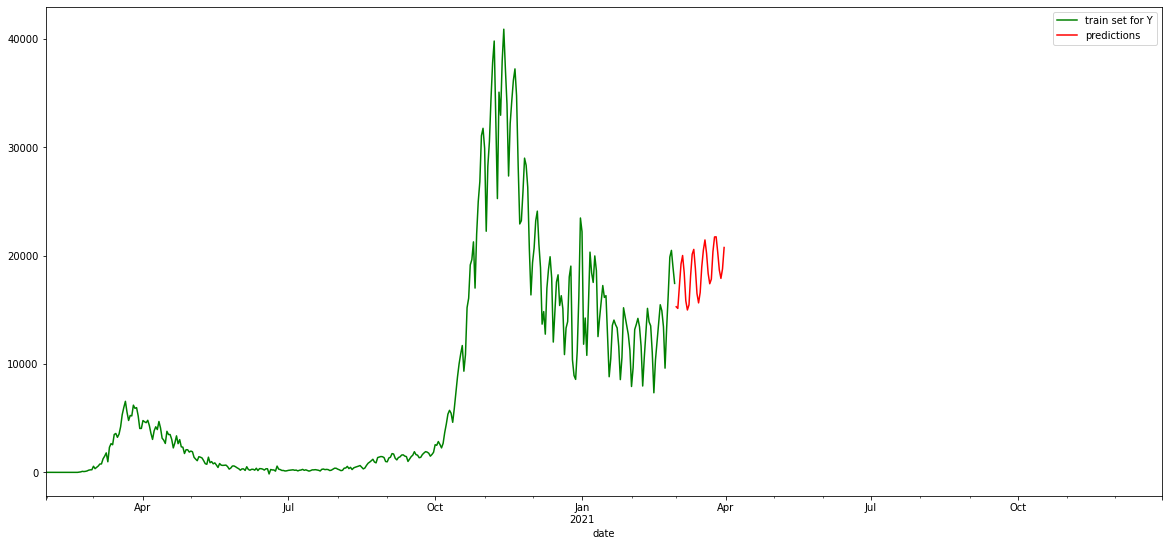

In [163]:
dateita=italia.copy()
italia.index = pd.DatetimeIndex(italia['date'], freq='D')
italia=italia.drop(columns='date')
italia= italia.select_dtypes(include=np.number)

train_y=italia['new_cases'].loc['2020-01-31':'2021-02-28']
xs=italia.drop(columns='new_cases')
train_X=xs.loc['2020-01-31':'2021-02-28']
test_X=xs.loc['2021-02-28':'2021-03-30']

train_y=pd.DataFrame(train_y)
train_y=train_y['new_cases'].fillna(np.mean(train_y['new_cases']))
train_y=train_y.dropna()

model=auto_arima(train_y,
                 exogenous=train_X 
                 )


realmodel= SARIMAX(train_y,
                    exog= train_X,
                    order=model.order,
                    seasonal_order=model.seasonal_order,
                    out_of_sample_size = 30
                    )

results= realmodel.fit()

predictions= results.predict(start =len(train_y), end=len(train_y)+30, exog=test_X)

predictions.index = pd.DatetimeIndex(dateita['date'][395:426], freq='D')

predictions=pd.DataFrame(predictions)

fig, ax = plt.subplots(figsize=(20,9))

italia['new_cases'].plot(color='green', ax=ax)
predictions.plot(color='red', ax=ax)
ax.legend(['train set for Y', 'predictions'])

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


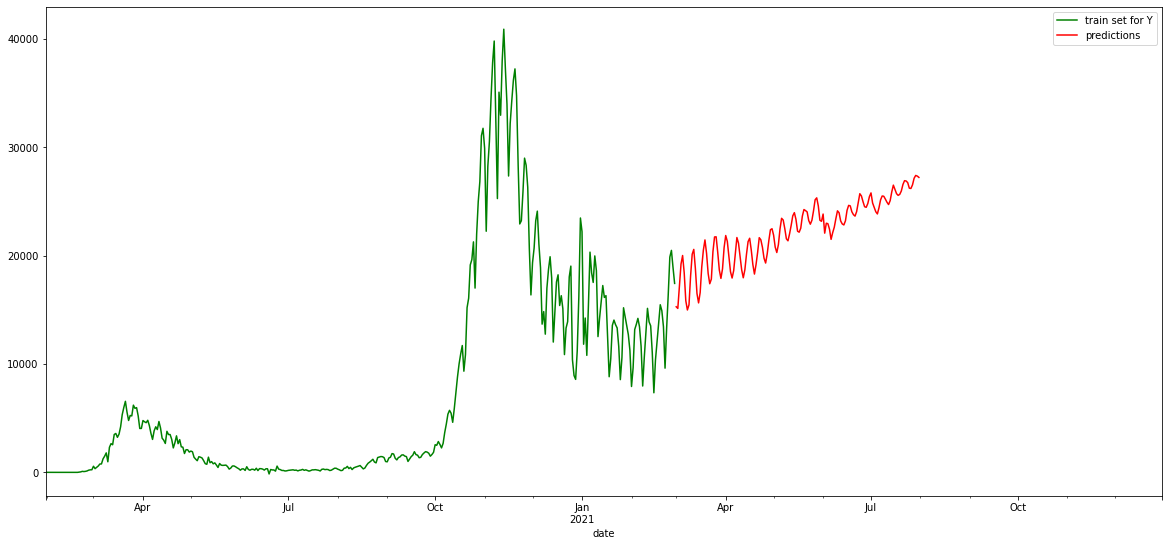

In [167]:
dateita=italia.copy()
italia.index = pd.DatetimeIndex(italia['date'], freq='D')
italia=italia.drop(columns='date')
italia= italia.select_dtypes(include=np.number)

train_y=italia['new_cases'].loc['2020-01-31':'2021-02-28']
xs=italia.drop(columns='new_cases')
train_X=xs.loc['2020-01-31':'2021-02-28']
test_X=xs.loc['2021-02-28':'2021-07-30']

train_y=pd.DataFrame(train_y)
train_y=train_y['new_cases'].fillna(np.mean(train_y['new_cases']))
train_y=train_y.dropna()

model=auto_arima(train_y,
                 exogenous=train_X 
                 )


realmodel= SARIMAX(train_y,
                    exog= train_X,
                    order=model.order,
                    seasonal_order=model.seasonal_order,
                    out_of_sample_size = 152
                    )

results= realmodel.fit()

predictions= results.predict(start =len(train_y), end=len(train_y)+152, exog=test_X)

predictions.index = pd.DatetimeIndex(dateita['date'][395:548], freq='D')

predictions=pd.DataFrame(predictions)

fig, ax = plt.subplots(figsize=(20,9))

italia['new_cases'].plot(color='green', ax=ax)
predictions.plot(color='red', ax=ax)
ax.legend(['train set for Y', 'predictions'])

In [ ]:
# italia=italia.drop(columns='Unnamed: 0')
# italia.index = pd.DatetimeIndex(italia['date'], freq='infer')
# italia=italia.drop(columns='date')
# italia=italia.drop(columns='total_cases')

# italia=italia[~italia['total_vaccinations'].isna()]
# italia= italia.select_dtypes(include=np.number)

# test_X = italia[italia['new_cases'].isna()].drop(columns='new_cases')
# italia = italia[(~italia['new_cases'].isna()) & ((italia[['new_cases']] >= 0).all(axis=1))]

# #italia = italia[(italia[['new_cases']] > 0).all(axis=1)]

# # res = sm.tsa.seasonal_decompose(italia['new_cases'],freq=7)
# # with plt.rc_context():
# #     plt.rc("figure", figsize=(12,12))
# #     print(res.plot())

# # steps=-7
# # predidf= italia.copy()
# # predidf['actual']=predidf['new_cases'].shift(steps)
# # predidf=predidf.dropna()
# # predidf['actual'].isna().sum()

# train_X, train_y = italia.drop(columns='new_cases'), italia['new_cases']
# train_y=pd.DataFrame(train_y)

# sc_in = MinMaxScaler(feature_range=(0, 1))
# train_X_scaled = sc_in.fit_transform(train_X)
# train_X_scaled =pd.DataFrame(train_X_scaled)

# test_X_scaled = sc_in.transform(test_X)
# test_X_scaled =pd.DataFrame(test_X_scaled)

# sc_out = MinMaxScaler(feature_range=(0, 1))
# train_y_scaled = sc_out.fit_transform(train_y)
# train_y_scaled =pd.DataFrame(train_y_scaled)

# train_X_scaled.rename(columns={0:'total_cases', 1:'total_vaccinations', 2:'stringency_index', 3:'stay_home_requirements', 
#                 4:'close_public_transport', 5:'cancel_public_events', 6:'facial_coverings',7:'school_closures',
#                 8:'TEMP', 9:'HUMIDITY',10:'WIND'}, inplace=True)
# train_X_scaled.index=train_X.index

# test_X_scaled.rename(columns={0:'total_cases', 1:'total_vaccinations', 2:'stringency_index', 3:'stay_home_requirements', 
#                 4:'close_public_transport', 5:'cancel_public_events', 6:'facial_coverings',7:'school_closures',
#                 8:'TEMP', 9:'HUMIDITY',10:'WIND'}, inplace=True)
# test_X_scaled.index=test_X.index

# train_y_scaled.rename(columns={0:'new_cases_next_week'}, inplace= True)
# train_y_scaled.index=train_y.index

# model=auto_arima(train_y_scaled, 
#                 exogenous= train_X_scaled,
#                 start_p=1, start_q=1, 
#                 max_p=7, max_q=7, 
#                 d=1, max_d=7,
#                 trace=True, 
#                 error_action='ignore', 
#                 # seasonal=True, m=1,
#                 suppress_warnings=True, 
#                 stepwise=True,
#                 out_of_sample_size = len(test_X))
# print(model.summary())

# model.plot_diagnostics(figsize=(7,5))
# print(plt.show())

# realmodel= SARIMAX(train_y_scaled, 
# exog=train_X_scaled,
# order=model.order,
# seasonal_order=model.seasonal_order,
# enforce_invertibility=False, enforce_stationarity=False)

# results= realmodel.fit()

# predictions= results.predict(start =len(train_X), end=len(train_X)+len(test_X)-1, exog=test_X_scaled)
# # predictions= results.predict(start =len(train_X), end=len(train_X)+(len(test_X)+(steps)-1), exog=test_X_scaled)

# predictions=pd.DataFrame(predictions)
# predictions.reset_index(drop=True, inplace=True)
# predictions.index=test_X.index
# predictions.rename(columns={'predicted_mean':'predicted'}, inplace=True)

# predictions['predicted']=predictions[(predictions['predicted'] > -0.5).replace(predictions['predicted'].mean())]
# predictions=predictions.dropna()

# testPredict = pd.DataFrame(sc_out.inverse_transform(predictions[['predicted']]))
# testPredict.index = pd.DatetimeIndex(test_X.index, freq='infer')

# fig, ax = plt.subplots(figsize=(20,9))
# print(train_y.plot(color='green', ax=ax))
# print(testPredict.plot(color='red', ax=ax))
# print(ax.legend(['train set for Y','predictions']))

## Time Series Validation / Walk Forward Validation

In [ ]:
errors=[]
for i in countries:
  try:
    country=countries[i]

    country.index = pd.DatetimeIndex(country['date'], freq='infer')
    country= country.select_dtypes(include=np.number)
    country = country.drop(columns=to_drop)
    country = country.drop(columns=drop_constant)
    country = country.drop(columns=drop_vacc)
    country = country[(country[['new_cases']] > 0).all(axis=1)]

    steps=-7
    predidf= country.copy()
    predidf['actual']=predidf['new_cases'].shift(steps)
    predidf=predidf.dropna()
    predidf['actual'].isna().sum()

    targ=pd.DataFrame(predidf['actual'])
    exo=predidf.drop(columns='actual')
    exo=exo.drop(columns='new_cases')

    train_size=int(len(country) *0.87)
    test_size = int(len(country)) - train_size
    train_X, train_y = exo[:train_size].dropna(), targ[:train_size].dropna()
    test_X, test_y = exo[train_size:].dropna(), targ[train_size:].dropna()

    model=auto_arima(train_y, 
                    exogenous= train_X,
                    start_p=1, start_q=1, 
                    max_p=7, max_q=7, 
                    d=1, max_d=7,
                    trace=True, 
                    error_action='ignore', 
                    # seasonal=True, m=1,
                    suppress_warnings=True, 
                    stepwise=True)
    # print(model.summary())

    realmodel= SARIMAX(train_y, 
    exog=train_X,
    order=model.order,
    seasonal_order=model.seasonal_order,
    enforce_invertibility=False, enforce_stationarity=False)

    results= realmodel.fit()

    predictions= results.predict(start =train_size, end=train_size+test_size+(steps)-1,exog=test_X)
    act= pd.DataFrame(test_y)

    predictions=pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index=test_X.index
    predictions['new_cases_next_week'] = act['actual']
    predictions.rename(columns={'predicted_mean':'predicted'}, inplace=True)

    predictions['predicted']=predictions[(predictions['predicted'] > -0.5).replace(predictions['predicted'].mean())]
    predictions=predictions.dropna()

    fig, ax = plt.subplots(figsize=(20,9))
    print(train_y.plot(color='green', ax=ax))
    print(predictions['new_cases_next_week'].plot(color='blue', ax=ax))
    print(predictions['predicted'].plot(color='red', ax=ax))
    print(plt.title(i))
    print(ax.legend(['train set for Y','test set for Y','predictions']))

    error=rmse(predictions['predicted'], predictions['new_cases_next_week'])
    errors.append(error)
  except:
    continue

In [ ]:
print(errors)

In [ ]:
import numpy as np

In [ ]:
errors=[53.13771756784765, 15252.279074225153, 670.1715323533014, 52.655656971519875, 23.819088769934538, 22.8719242634738, 35.06622413567648, 2436.723201209044, 121.7924002514476, 11978.635064832657, 29.804615475351333, 480.4513704839793, 152.4081067011823, 15.880476610597428, 346.10756119871786, 692.608082991754, 66.09032233565203, 462.6697101629872, 1471.8202994108303, 56.04214407228459, 134.2601799333723, 1.548708786229126, 703.8797441852785, 286.13578389230423, 307.1453374864421, 18594.85313091974, 728.4993303800222, 66.07028164398484, 19.555851199608956, 29.435513253180762, 344.7176798164596, 5898.351432245688, 42.97540354323347, 129.10923206228543, 23.542676178678985, 7164.560278888941, 91.72285228339655, 10270.162939492122, 17.577253892969292, 127.83493343309077, 781.9529181844491, 117.27154472596841, 230.45892064593437, 476.07014411297405, 77.59227017275289, 5270.220197901695, 94.91574152614908, 478.05592331876755, 7.811573219292359, 321.7424893087943, 1082.564645409621, 152.77146477856516, 430.56448116471654, 37.13891691642583, 35.9856001160077, 269.2284601834597, 82.77404101676414, 321.0856000885077, 55849.561381377505, 47778.06269882405, 142.31099007083122, 22318.697599151863, 225.06802672334936, 31.892462957646273, 289.3166406581409, 8296.484379867532, 528.8245107573681, 788.7143312252667, 616.3620793242337, 53.77827296625908, 12.552987595081078, 27.754784810630102, 48.45523456067038, 574.10706127174, 1380.6720274786837, 16.609926119585744, 1994.6147978641031, 2581.8927054701307, 1150.0804617144684, 1709.8743932857008, 2129.202639935588, 2829.579191748081, 149.99365774131073, 5281.8891212215485, 1224.7268033314147, 968.3961320481951, 181.665379158474, 388.8786767276622, 448.47529660723274, 246.65019526283464, 185.25665281949694, 1205.421813700595, 77.68224761494757, 20.25008284222121, 483.4937932299453, 4.856697403287986, 303.66916586562866, 709.6826197370626, 514.332571744247, 925.1090775505147, 78.55221384663464, 50.35082508273972, 45.5697963932409, 7.927151810202727, 5.601289593914446, 39761.45150431034, 448.7003644326349, 21.08501816472999, 11.063955085125704, 95.64331109046255, 486.97399592382294, 253.66129607401288, 248.0053102309158, 76.76396492182732, 362.44789262994703, 1028.3655290128124, 4.64097247619663, 24.640803508912953, 587.3218555540174, 133481.55138149025, 248.9231894490613, 353.0524894236525, 23.720240127483645, 178.92244016328965, 723.6955231433903, 377.0446997446484, 1264.5172911754814, 49.61339823229007, 395.3944579507049, 9893.052596743264, 1190.120099194415, 5600.04594098497, 8701.598310012148, 167.8770832954665, 1529.699263184038, 8073.536306860523, 101.08399143872052, 90.04153461277403, 11.059380354339389, 21.36754206290567, 20.288076666710186, 198.26225657040345, 89.40543897694768, 1053.419193829543, 13.10150022465728, 34.91449651297733, 37.330807690435066, 1017.2292792908331, 371.28660788721857, 118.83076234299344, 4673.381568945139, 25146.722271112783, 174.57728802573115, 76.32660253166887, 62239.370980297, 171.58957251161362, 231.83588418239555, 42.740007907452075, 5895.786659118304, 2575.9070148695546, 25.020710347412304, 6.206719360911891, 22.480101556531537, 370.91699758095166, 43.84588865324406, 11.862435507354775, 2940.5123346445066, 2943.35377238841, 406.90887960292673, 1436.9542180025298, 517.9579951853301, 28358.24173987085, 153936.98491839215, 189.13674187190878, 24.985518192985015, 99.81941790238584, 48.57077383072522, 331206.0335602422, 9.294003315579818, 525.7223861833606, 183.74920597720399]

In [ ]:
len(errors)

In [ ]:
print('min error is: ', min(errors))
print('max error is: ', max(errors))
print('avg error is: ',np.mean(errors))

min error is:  1.548708786229126
max error is:  331206.0335602422
avg error is:  6065.920587947992


In [ ]:
errors=pd.DataFrame(errors)

In [ ]:
sns.displot(errors)
plt.show()

In [ ]:
#%%
'''
Expanding window cross validation
Similar to sklearn format
@ germayne  
'''
import numpy as np

class expanding_window(object):
    '''	
    Parameters 
    ----------
    
    Note that if you define a horizon that is too far, then subsequently the split will ignore horizon length 
    such that there is validation data left. This similar to Prof Rob hyndman's TsCv 
    
    
    initial: int
        initial train length 
    horizon: int 
        forecast horizon (forecast length). Default = 1
    period: int 
        length of train data to add each iteration 
    '''
    

    def __init__(self,initial= 1,horizon = 1,period = 1):
        self.initial = initial
        self.horizon = horizon 
        self.period = period 


    def split(self,data):
        '''
        Parameters 
        ----------
        
        Data: Training data 
        
        Returns 
        -------
        train_index ,test_index: 
            index for train and valid set similar to sklearn model selection
        '''
        self.data = data
        self.counter = 0 # for us to iterate and track later 


        data_length = data.shape[0] # rows 
        data_index = list(np.arange(data_length))
         
        output_train = []
        output_test = []
        # append initial 
        output_train.append(list(np.arange(self.initial)))
        progress = [x for x in data_index if x not in list(np.arange(self.initial)) ] # indexes left to append to train 
        output_test.append([x for x in data_index if x not in output_train[self.counter]][:self.horizon] )
        # clip initial indexes from progress since that is what we are left 
         
        while len(progress) != 0:
            temp = progress[:self.period]
            to_add = output_train[self.counter] + temp
            # update the train index 
            output_train.append(to_add)
            # increment counter 
            self.counter +=1 
            # then we update the test index 
            
            to_add_test = [x for x in data_index if x not in output_train[self.counter] ][:self.horizon]
            output_test.append(to_add_test)

            # update progress 
            progress = [x for x in data_index if x not in output_train[self.counter]]	
            
        # clip the last element of output_train and output_test
        output_train = output_train[:-1]
        output_test = output_test[:-1]
        
        # mimic sklearn output 
        index_output = [(train,test) for train,test in zip(output_train,output_test)]
        
        return index_output
        
        
#%%
#%%
# demo 

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])

y = np.array([1, 2, 3, 4, 5, 6])
tscv = expanding_window()
for train_index, test_index in tscv.split(X):
    print(train_index)
    print(test_index)



X = np.random.randint(0,1000,size = (120,2))
y = np.random.randint(0,1000,size = (120,1))

tscv = expanding_window(initial = 36, horizon = 24,period = 1)
for train_index, test_index in tscv.split(X):
    print(train_index)
    print(test_index)
#%%

In [ ]:
prediction = []
data = train.values
for t in test.values:
   model = (ExponentialSmoothing(data).fit())
   y = model.predict()
   prediction.append(y[0])
   data = numpy.append(data, t)

test_ = pandas.DataFrame(test)
test_['predictionswf'] = prediction

plt.plot(test_['T'])
plt.plot(test_.predictionswf, '--')
plt.show()

error = sqrt(metrics.mean_squared_error(test.values,prediction))
print ('Test RMSE for Triple Exponential Smoothing with Walk-Forward Validation: ', error)

# Time Series / NEURAL NETWORK

In [ ]:
targ=pd.DataFrame(predidf['actual'])

In [ ]:
targ=targ.dropna()

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
# dataset = dataframe.values
# dataset = dataset.astype('float32')

# normalize the dataset (**scaling after the train-test split**)
dataset=targ
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(targ)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
# train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
targ.tail(10)

In [ ]:
itanum=italy.select_dtypes(np.number)

In [ ]:
itanum

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(itanum)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, train.y, look_back)
testX, testY = create_dataset(test, test.y, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
Brazil=countries['Brazil']

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
  a = dataset[i:(i+look_back), 0]
  dataX.append(a)
  dataY.append(dataset[i + look_back, 0])
 return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(Brazil)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
Brazil.index = pd.DatetimeIndex(Brazil['date'], freq=None)

In [ ]:
Brazil=Brazil['new_cases']

In [ ]:
Brazil=pd.DataFrame(Brazil)